In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px 
from datetime import datetime as dt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
from sklearn import tree

# sklean imports 
from sklearn import metrics 

from sklearn.linear_model import *
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import *
from sklearn.neural_network import MLPRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import *


pd.set_option('display.float_format', lambda x: '%.5f' % x) # pandas
np.set_printoptions(precision=5, suppress=True) # numpy

In [2]:
sns.set_style({
    'text.color': 'white',
    'xtick.color': 'white',
    'ytick.color': 'white',
    'axes.edgecolor': 'white',
    'axes.labelcolor': 'white',
    'figure.facecolor': 'black',
    'axes.facecolor': 'black',

})

### Functions

In [3]:
def tsplot(y, lags=None, title='', figsize=(14, 8)):
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax   = plt.subplot2grid(layout, (0, 0))
    hist_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax  = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    
    y.plot(ax=ts_ax)
    ts_ax.set_title(title)
    y.plot(ax=hist_ax, kind='hist', bins=25)
    hist_ax.set_title('Histogram')
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    [ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    fig.tight_layout()
    return ts_ax, acf_ax, pacf_ax

In [4]:
random_state=42

In [5]:
hour_df = pd.read_csv('hour.csv')
display(hour_df)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24000,0.28790,0.81000,0.00000,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22000,0.27270,0.80000,0.00000,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22000,0.27270,0.80000,0.00000,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24000,0.28790,0.75000,0.00000,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24000,0.28790,0.75000,0.00000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,17375,2012-12-31,1,1,12,19,0,1,1,2,0.26000,0.25760,0.60000,0.16420,11,108,119
17375,17376,2012-12-31,1,1,12,20,0,1,1,2,0.26000,0.25760,0.60000,0.16420,8,81,89
17376,17377,2012-12-31,1,1,12,21,0,1,1,1,0.26000,0.25760,0.60000,0.16420,7,83,90
17377,17378,2012-12-31,1,1,12,22,0,1,1,1,0.26000,0.27270,0.56000,0.13430,13,48,61


# EDA

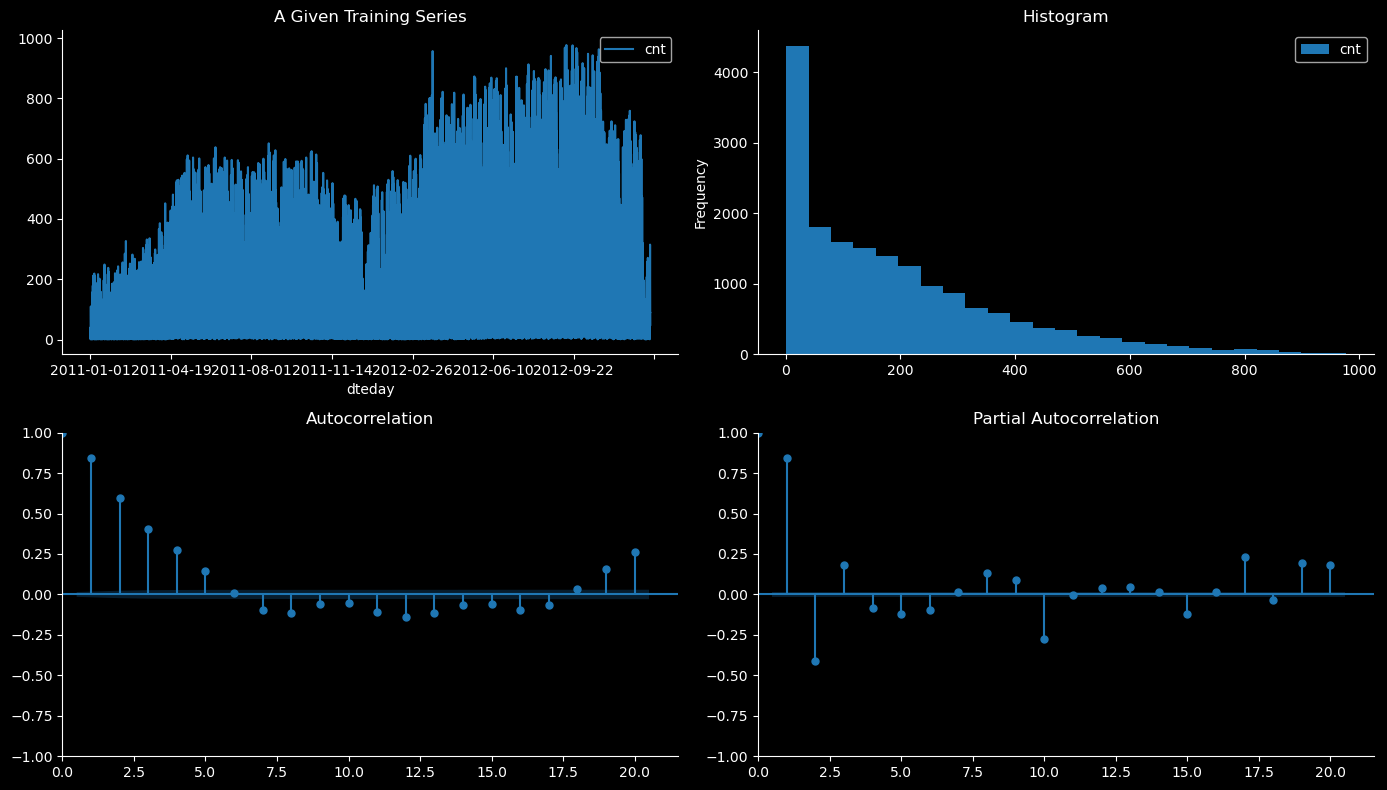

In [6]:
temp = hour_df[['dteday', 'cnt']]
temp.set_index('dteday', inplace=True)
tsplot(temp, title='A Given Training Series', lags=20);

### Continous Variables

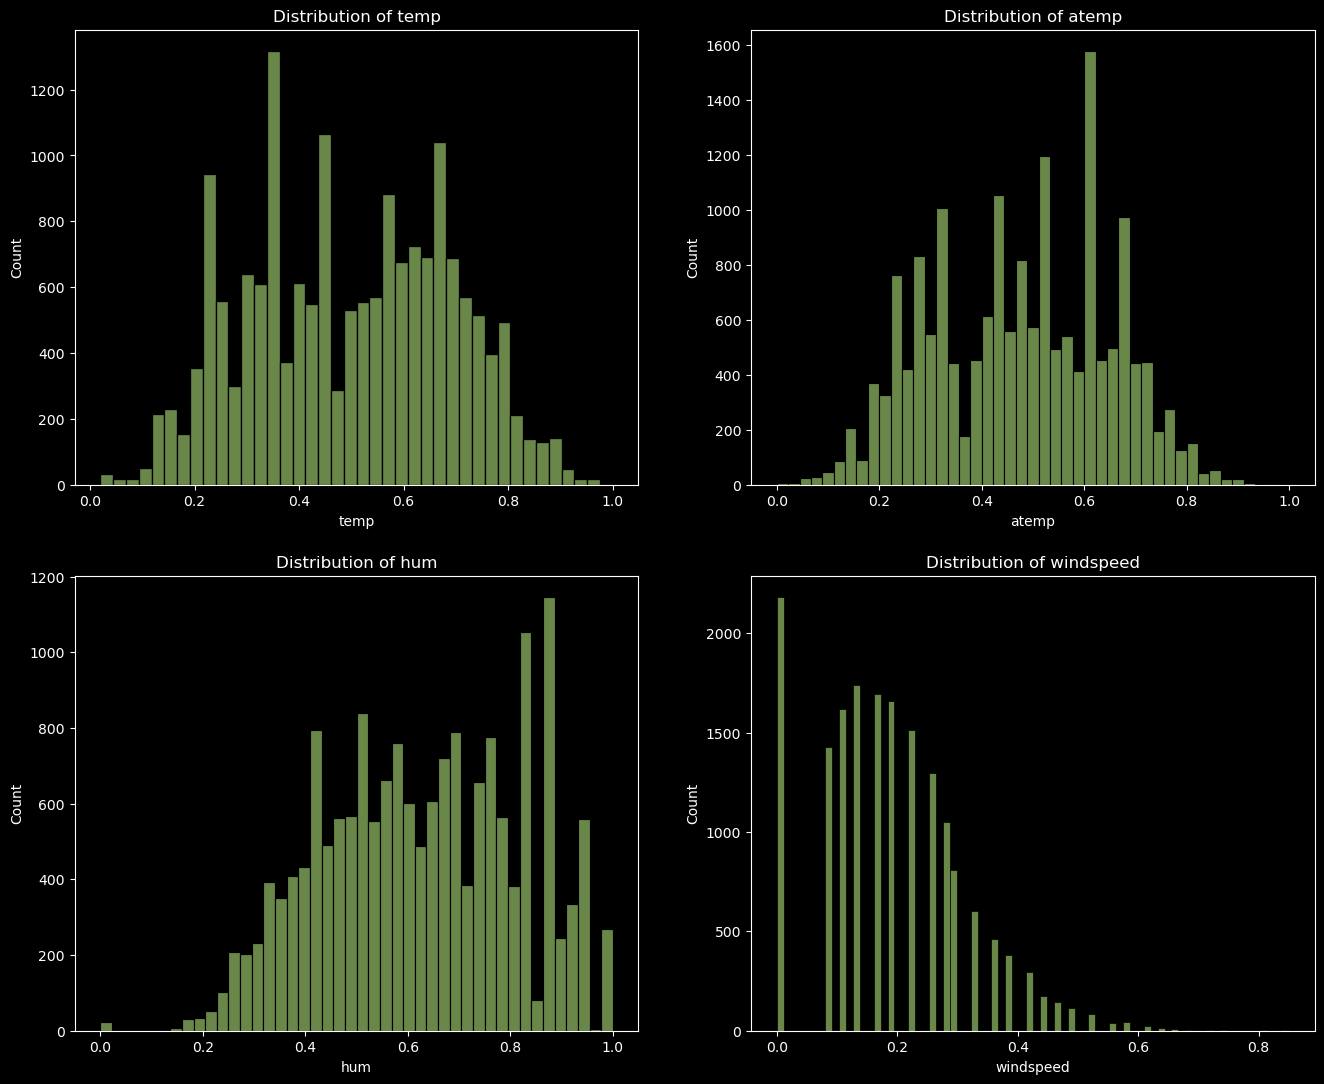

In [7]:
figure, axes = plt.subplots(ncols=2, nrows=2)
figure.set_size_inches(16, 13)

sns.histplot(hour_df['temp'], ax=axes[0][0], color='#8cb561', edgecolor="k")
axes[0][0].set_title('Distribution of temp')

sns.histplot(hour_df['atemp'], ax=axes[0][1], color='#8cb561', edgecolor="k")
axes[0][1].set_title('Distribution of atemp')

sns.histplot(hour_df['hum'], ax=axes[1][0], color='#8cb561', edgecolor="k")
axes[1][0].set_title('Distribution of hum')

sns.histplot(hour_df['windspeed'], ax=axes[1][1], color='#8cb561', edgecolor="k")
axes[1][1].set_title('Distribution of windspeed')

plt.savefig('graph_1.png', dpi=300, transparent=True)
plt.show()

### Categorial Variables

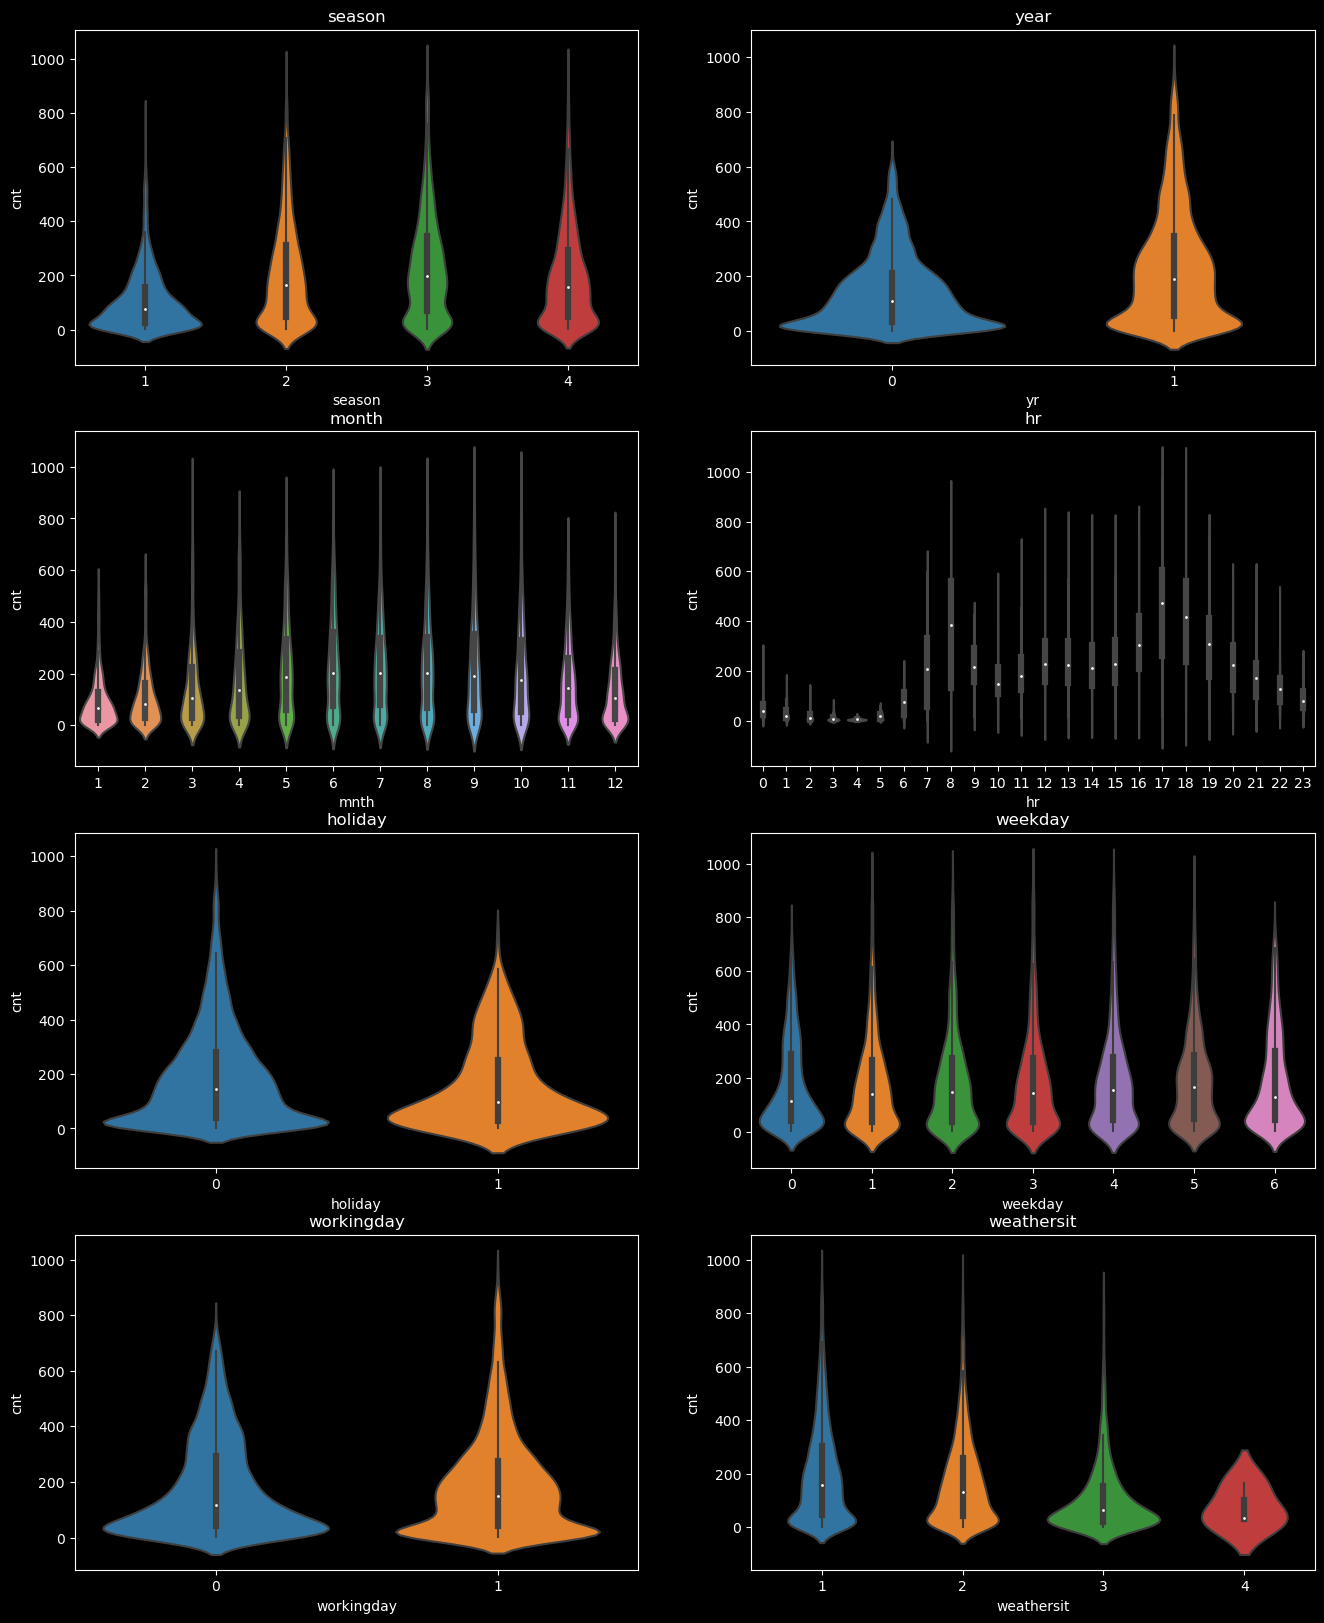

In [8]:
figure, axes = plt.subplots(ncols=2, nrows=4)
figure.set_size_inches(16, 20)


sns.violinplot(data = hour_df, x='season', y='cnt', ax=axes[0][0])
axes[0][0].set_title('season')
sns.violinplot(data = hour_df, x='yr', y='cnt', ax=axes[0][1])
axes[0][1].set_title('year')

sns.violinplot(data = hour_df, x='mnth', y='cnt', ax=axes[1][0])
axes[1][0].set_title('month')
sns.violinplot(data = hour_df, x='hr', y='cnt', ax=axes[1][1])
axes[1][1].set_title('hr')

sns.violinplot(data = hour_df, x='holiday', y='cnt', ax=axes[2][0])
axes[2][0].set_title('holiday')
sns.violinplot(data = hour_df, x='weekday', y='cnt', ax=axes[2][1])
axes[2][1].set_title('weekday')

sns.violinplot(data = hour_df, x='workingday', y='cnt', ax=axes[3][0])
axes[3][0].set_title('workingday')
sns.violinplot(data = hour_df, x='weathersit', y='cnt', ax=axes[3][1])
axes[3][1].set_title('weathersit')

plt.savefig('graph_2.png', dpi=300, transparent=True)
plt.show()

# Cleaning and feature engineering

In [9]:
hour_df['year'] = pd.to_datetime(hour_df["dteday"]).dt.year
hour_df['month'] = pd.to_datetime(hour_df["dteday"]).dt.month
hour_df['day'] = pd.to_datetime(hour_df["dteday"]).dt.day
hour_df_date = hour_df.copy()
hour_df.drop('dteday', axis=1, inplace=True)
hour_df.drop('yr', axis=1, inplace=True)
hour_df.drop('mnth', axis=1, inplace=True)
hour_df

,instant,season,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,year,month,day
0,1,1,0,0,6,0,1,0.24000,0.28790,0.81000,0.00000,3,13,16,2011,1,1
1,2,1,1,0,6,0,1,0.22000,0.27270,0.80000,0.00000,8,32,40,2011,1,1
2,3,1,2,0,6,0,1,0.22000,0.27270,0.80000,0.00000,5,27,32,2011,1,1
3,4,1,3,0,6,0,1,0.24000,0.28790,0.75000,0.00000,3,10,13,2011,1,1
4,5,1,4,0,6,0,1,0.24000,0.28790,0.75000,0.00000,0,1,1,2011,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,17375,1,19,0,1,1,2,0.26000,0.25760,0.60000,0.16420,11,108,119,2012,12,31
17375,17376,1,20,0,1,1,2,0.26000,0.25760,0.60000,0.16420,8,81,89,2012,12,31
17376,17377,1,21,0,1,1,1,0.26000,0.25760,0.60000,0.16420,7,83,90,2012,12,31
17377,17378,1,22,0,1,1,1,0.26000,0.27270,0.56000,0.13430,13,48,61,2012,12,31


In [10]:
hour_df['season'] = hour_df['season'].replace([1,2,3,4],['winter',
                                                         'spring',
                                                         'summer',
                                                         'fall'])

hour_df['weekday'] = hour_df['weekday'].replace([0,1,2,3,4,5,6],['Sunday',
                                                                 'Monday',
                                                                 'Tuesday',
                                                                 'Wednesday',
                                                                 'Thursday',
                                                                 'Friday',
                                                                 'Saturday'
                                                                ])

hour_df = pd.get_dummies(hour_df, 
                         columns=['season', 'weekday'], 
                         drop_first=True, 
                         dtype=int)

hour_df.drop('atemp', axis=1, inplace=True)


### Splitting to train test

In [11]:
# split by using the first 80% of data as the training
train_df = hour_df[hour_df['instant']<len(hour_df)*.8]
test_df = hour_df[hour_df['instant']>len(hour_df)*.8]
train_df = pd.DataFrame(train_df)
test_df = pd.DataFrame(test_df)

train_df.drop('instant', axis=1, inplace=True)
test_df.drop('instant', axis=1, inplace=True)

display(train_df)
display(test_df)

,hr,holiday,workingday,weathersit,temp,hum,windspeed,casual,registered,cnt,...,day,season_spring,season_summer,season_winter,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday
0,0,0,0,1,0.24000,0.81000,0.00000,3,13,16,...,1,0,0,1,0,1,0,0,0,0
1,1,0,0,1,0.22000,0.80000,0.00000,8,32,40,...,1,0,0,1,0,1,0,0,0,0
2,2,0,0,1,0.22000,0.80000,0.00000,5,27,32,...,1,0,0,1,0,1,0,0,0,0
3,3,0,0,1,0.24000,0.75000,0.00000,3,10,13,...,1,0,0,1,0,1,0,0,0,0
4,4,0,0,1,0.24000,0.75000,0.00000,0,1,1,...,1,0,0,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13898,7,0,1,2,0.70000,0.74000,0.13430,21,481,502,...,7,0,1,0,0,0,0,0,1,0
13899,8,0,1,2,0.70000,0.70000,0.16420,41,664,705,...,7,0,1,0,0,0,0,0,1,0
13900,9,0,1,2,0.70000,0.74000,0.13430,44,283,327,...,7,0,1,0,0,0,0,0,1,0
13901,10,0,1,2,0.74000,0.70000,0.13430,89,161,250,...,7,0,1,0,0,0,0,0,1,0


,hr,holiday,workingday,weathersit,temp,hum,windspeed,casual,registered,cnt,...,day,season_spring,season_summer,season_winter,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday
13903,12,0,1,2,0.80000,0.55000,0.13430,86,197,283,...,7,0,1,0,0,0,0,0,1,0
13904,13,0,1,2,0.80000,0.52000,0.19400,68,185,253,...,7,0,1,0,0,0,0,0,1,0
13905,14,0,1,2,0.82000,0.46000,0.00000,76,185,261,...,7,0,1,0,0,0,0,0,1,0
13906,15,0,1,1,0.80000,0.52000,0.00000,100,206,306,...,7,0,1,0,0,0,0,0,1,0
13907,16,0,1,3,0.76000,0.66000,0.28360,101,344,445,...,7,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,19,0,1,2,0.26000,0.60000,0.16420,11,108,119,...,31,0,0,1,1,0,0,0,0,0
17375,20,0,1,2,0.26000,0.60000,0.16420,8,81,89,...,31,0,0,1,1,0,0,0,0,0
17376,21,0,1,1,0.26000,0.60000,0.16420,7,83,90,...,31,0,0,1,1,0,0,0,0,0
17377,22,0,1,1,0.26000,0.56000,0.13430,13,48,61,...,31,0,0,1,1,0,0,0,0,0


In [12]:
X_test = test_df.drop(['casual', 'registered', 'cnt'], axis=1)
y_test = test_df['cnt']

In [13]:
features = train_df.columns.values
X_train, X_val, y_train, y_val = train_test_split(train_df.drop(['casual', 'registered', 'cnt'], axis=1),
                                                  train_df['cnt'], test_size=.3, random_state=0 
                                                 )

In [14]:
X_val

,hr,holiday,workingday,weathersit,temp,hum,windspeed,year,month,day,season_spring,season_summer,season_winter,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday
13528,21,0,0,1,0.70000,0.79000,0.10450,2012,7,22,0,1,0,0,0,1,0,0,0
776,19,0,1,2,0.24000,0.65000,0.13430,2011,2,4,0,0,1,0,0,0,0,0,0
11172,17,0,0,1,0.70000,0.42000,0.32840,2012,4,15,1,0,0,0,0,1,0,0,0
519,18,0,0,1,0.12000,0.30000,0.25370,2011,1,23,0,0,1,0,0,1,0,0,0
8551,1,0,1,1,0.32000,0.76000,0.16420,2011,12,28,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3630,4,0,0,2,0.62000,0.65000,0.16420,2011,6,5,1,0,0,0,0,1,0,0,0
2350,20,0,1,2,0.42000,0.82000,0.28360,2011,4,12,1,0,0,0,0,0,0,1,0
9824,7,0,0,2,0.24000,0.52000,0.28360,2012,2,19,0,0,1,0,0,1,0,0,0
13599,20,0,1,1,0.74000,0.40000,0.16420,2012,7,25,0,1,0,0,0,0,0,0,1


# Functions

In [15]:
def rmsle(y_true, y_pred, convertExp=True):
    if convertExp:
        y_true = np.exp(y_true)
        y_pred = np.exp(y_pred)
    
    log_true = np.nan_to_num(np.log(y_true + 1))
    log_pred = np.nan_to_num(np.log(y_pred + 1)) # convert missing value to 0
    
    output = np.sqrt(np.mean((log_true - log_pred) ** 2))
    return output

rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False)

In [16]:
comparison = pd.DataFrame()
mdl_lst = []
train_RMSLE_lst = []
val_RMSLE_lst = []


# Time Series Modelling

### Linear Trend

In [17]:
parameters = {
              "mdl__fit_intercept": [True],
             }

model = Pipeline(steps=[("mdl", LinearRegression())])

grid_search = GridSearchCV(estimator=model,
                           param_grid=parameters,
                           n_jobs=-2, 
                           cv=10,
                           scoring=rmsle_scorer
                          )

log_y_train = np.log(y_train)
time_series_fitted = grid_search.fit(X_train[['year', 'month', 'day', 'hr']], log_y_train)

print("Best: %f using %s" % (time_series_fitted.best_score_, time_series_fitted.best_params_))

#-----------------------------------------------------------------------------------------------------
preds = time_series_fitted.best_estimator_.predict(X_train[['year', 'month', 'day', 'hr']])
print(f'Training RMSLE of Linear Regression: {rmsle(log_y_train, preds, True): .4f}')
mdl_lst.append('Linear Trend')
train_RMSLE_lst.append(rmsle(log_y_train, preds, True))

log_y_val = np.log(y_val)
preds = time_series_fitted.best_estimator_.predict(X_val[['year', 'month', 'day', 'hr']])
print(f'Validation RMSLE of Linear Regression: {rmsle(log_y_val, preds, True): .4f}')
val_RMSLE_lst.append(rmsle(log_y_val, preds, True))

Best: -1.114726 using {'mdl__fit_intercept': True}
Training RMSLE of Linear Regression:  1.1142
Validation RMSLE of Linear Regression:  1.1266


C:\Users\Sean Law\AppData\Local\Temp\ipykernel_6904\3761413341.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.log(y_val), ax=axes[0], bins=50, color='#8cb561')
C:\Users\Sean Law\AppData\Local\Temp\ipykernel_6904\3761413341.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(preds, ax=axe

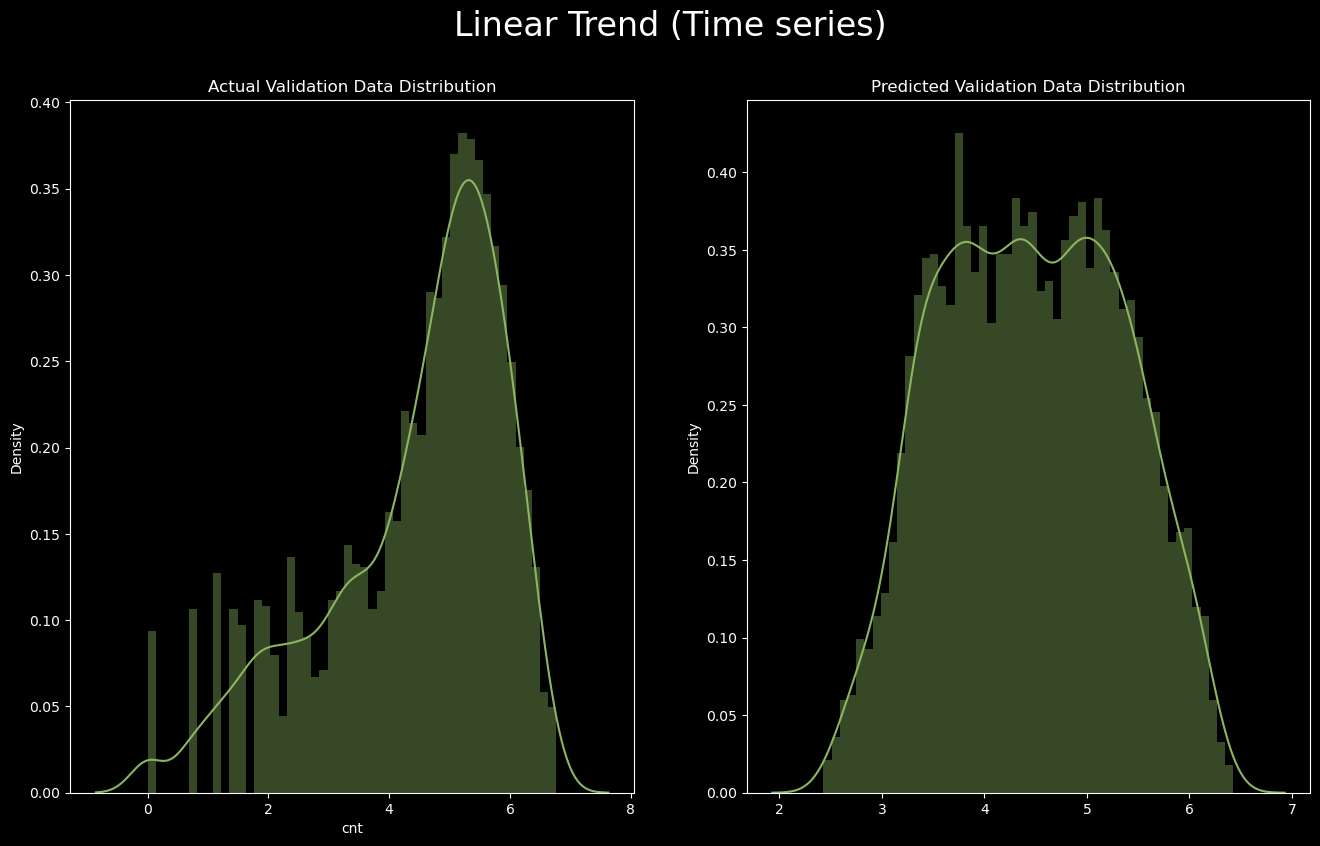

In [18]:
figure, axes = plt.subplots(ncols=2)
figure.set_size_inches(16, 9)

sns.distplot(np.log(y_val), ax=axes[0], bins=50, color='#8cb561')
axes[0].set_title('Actual Validation Data Distribution')
sns.distplot(preds, ax=axes[1], bins=50, color='#8cb561')
axes[1].set_title('Predicted Validation Data Distribution')
plt.suptitle('Linear Trend (Time series)', fontsize = 24)

plt.savefig('Linear_Trend_performance_dist.png', dpi=300, transparent=True)
plt.show()

### ARIMA

In [19]:
train_df_arima = hour_df_date[hour_df_date['instant']<len(hour_df_date)*.8]
test_df_arima = hour_df_date[hour_df_date['instant']>len(hour_df_date)*.8]


train_df_arima = train_df_arima[['dteday', 'cnt']]
test_df_arima = test_df_arima[['dteday', 'cnt']]

train_df_arima.set_index('dteday', inplace=True)
test_df_arima.set_index('dteday', inplace=True)
print(len(test_df))


arima200 = sm.tsa.SARIMAX(train_df_arima, order=(2,0,0))
model = arima200.fit()
model.summary()

3476


C:\Users\Sean Law\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Sean Law\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    cnt   No. Observations:                13903
Model:               SARIMAX(2, 0, 0)   Log Likelihood              -81567.846
Date:                Mon, 15 Apr 2024   AIC                         163141.692
Time:                        18:29:16   BIC                         163164.312
Sample:                             0   HQIC                        163149.225
                              - 13903                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2504      0.006    219.265      0.000       1.239       1.262
ar.L2         -0.3504      0.008    -44.697      0.000      -0.366      -0.335
sigma2      7302.3409     46.015    158.695      0.000    7212.153    7392.529
===================================================================================
Ljung-Box (L1) (Q):                  33.23   Jarque-Bera (JB):             20038.90
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.82   Skew:                            -0.02
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

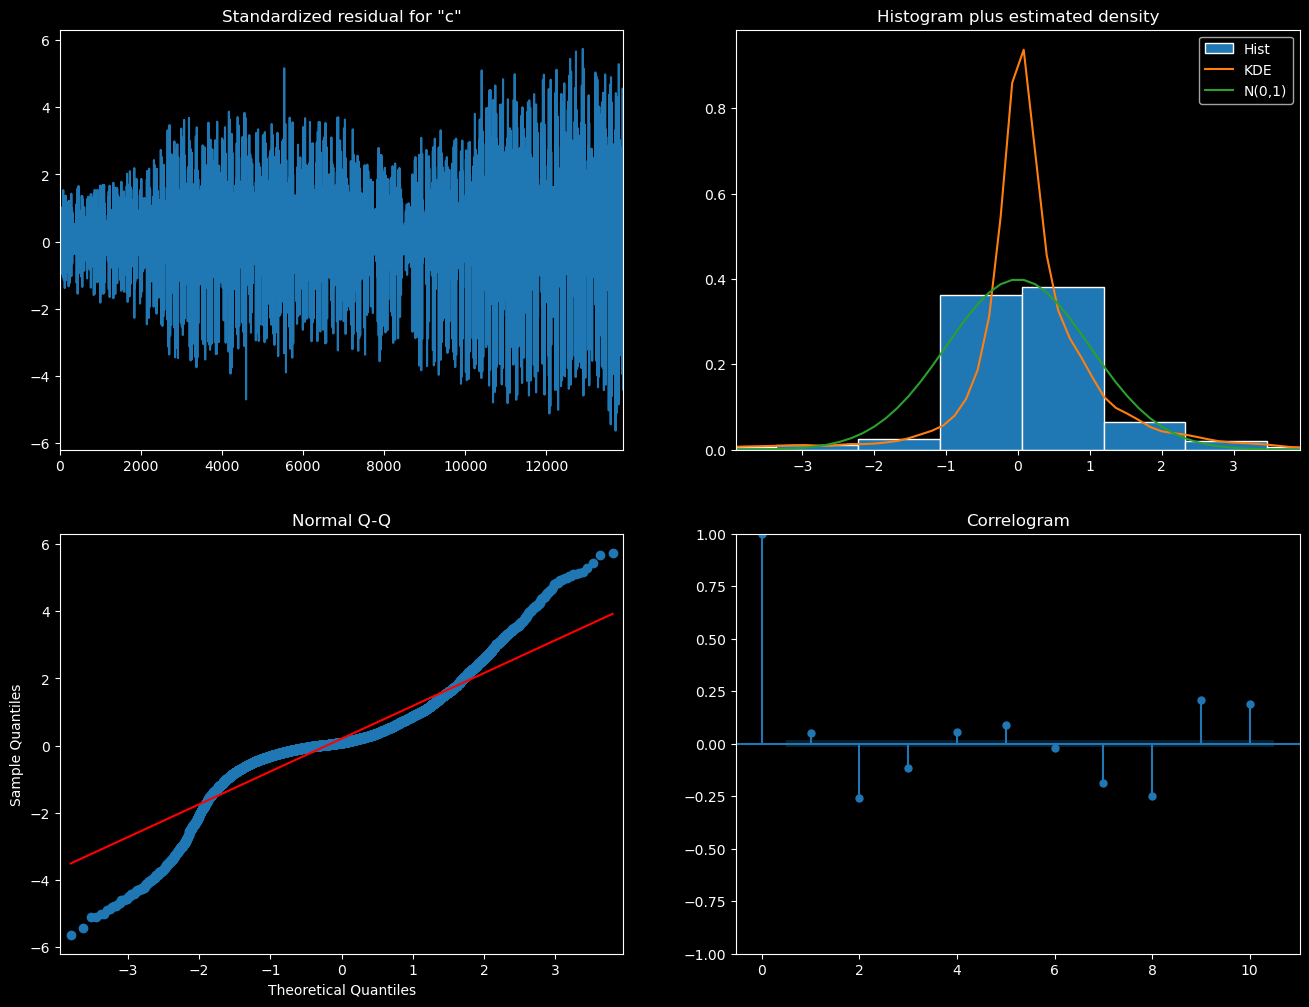

In [20]:
model.plot_diagnostics(figsize=(16, 12));

In [21]:
y_pred = pd.Series(model.forecast(9732))
print(f'Train RMSLE of ARIMA: {rmsle(np.log(y_train), np.log(y_pred), True): .4f}')
mdl_lst.append('ARIMA')
train_RMSLE_lst.append(rmsle(np.log(y_train), np.log(y_pred), True))

y_pred = pd.Series(model.forecast(4171))
log_y_val = np.log(y_val)
print(f'Validation RMSLE of ARIMA: {rmsle(log_y_val, np.log(y_pred), True): .4f}')
val_RMSLE_lst.append(rmsle(log_y_val, np.log(y_pred), True))

Train RMSLE of ARIMA:  4.7206
Validation RMSLE of ARIMA:  4.6771


C:\Users\Sean Law\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Sean Law\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\Sean Law\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


C:\Users\Sean Law\AppData\Local\Temp\ipykernel_6904\2619534737.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.log(y_val), ax=axes[0], bins=50, color='#8cb561')
C:\Users\Sean Law\AppData\Local\Temp\ipykernel_6904\2619534737.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(preds, ax=axe

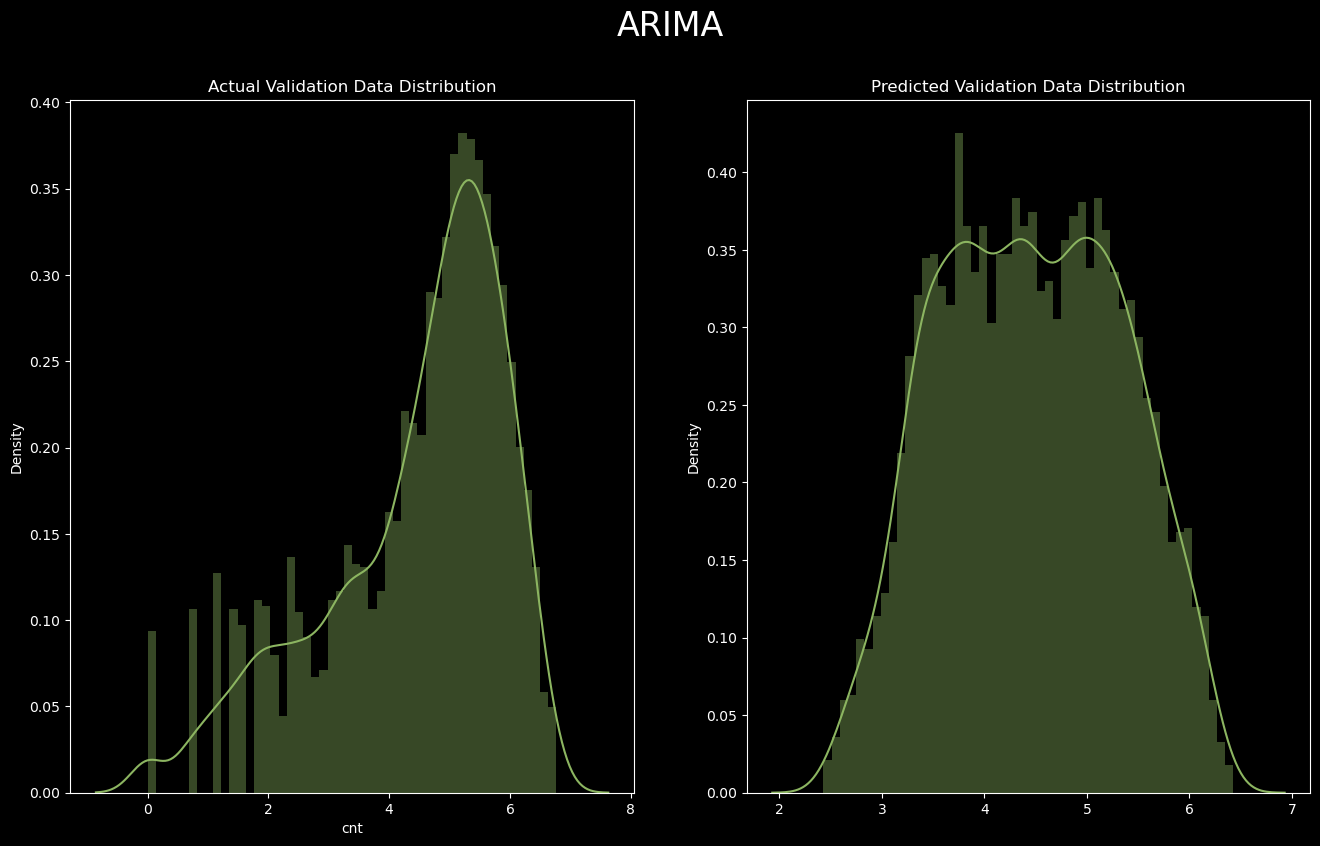

In [22]:
figure, axes = plt.subplots(ncols=2)
figure.set_size_inches(16, 9)

sns.distplot(np.log(y_val), ax=axes[0], bins=50, color='#8cb561')
axes[0].set_title('Actual Validation Data Distribution')
sns.distplot(preds, ax=axes[1], bins=50, color='#8cb561')
axes[1].set_title('Predicted Validation Data Distribution')
plt.suptitle('ARIMA', fontsize = 24)

plt.savefig('ARIMA_performance_dist.png', dpi=300, transparent=True)
plt.show()

# Linear Regression 

In [23]:
parameters = {
              "mdl__fit_intercept": [True],
             }

preprocessor = ColumnTransformer(
    transformers=[('scaler', PowerTransformer(), ['temp', 'hum', 'windspeed'])],
    remainder='passthrough'
)

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ("mdl", LinearRegression())
])



grid_search = GridSearchCV(estimator=model,
                           param_grid=parameters,
                           n_jobs=-2, 
                           cv=10,
                           scoring=rmsle_scorer
                          )

lin_reg = grid_search.fit(X_train, np.log(y_train))

print("Best: %f using %s" % (lin_reg.best_score_, lin_reg.best_params_))

#-----------------------------------------------------------------------------------------------------
preds = lin_reg.best_estimator_.predict(X_train)
print(f'Training RMSLE of Linear Regression: {rmsle(log_y_train, preds, True): .4f}')
mdl_lst.append('Linear Regression')
train_RMSLE_lst.append(rmsle(log_y_train, preds, True))

log_y_val = np.log(y_val)
preds = lin_reg.best_estimator_.predict(X_val)
print(f'Validation RMSLE of Linear Regression: {rmsle(log_y_val, preds, True): .4f}')
val_RMSLE_lst.append(rmsle(log_y_val, preds, True))

Best: -1.009731 using {'mdl__fit_intercept': True}
Training RMSLE of Linear Regression:  1.0078
Validation RMSLE of Linear Regression:  1.0185


C:\Users\Sean Law\AppData\Local\Temp\ipykernel_6904\640350398.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.log(y_val), ax=axes[0], bins=50, color='#8cb561')
C:\Users\Sean Law\AppData\Local\Temp\ipykernel_6904\640350398.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(preds, ax=axes[

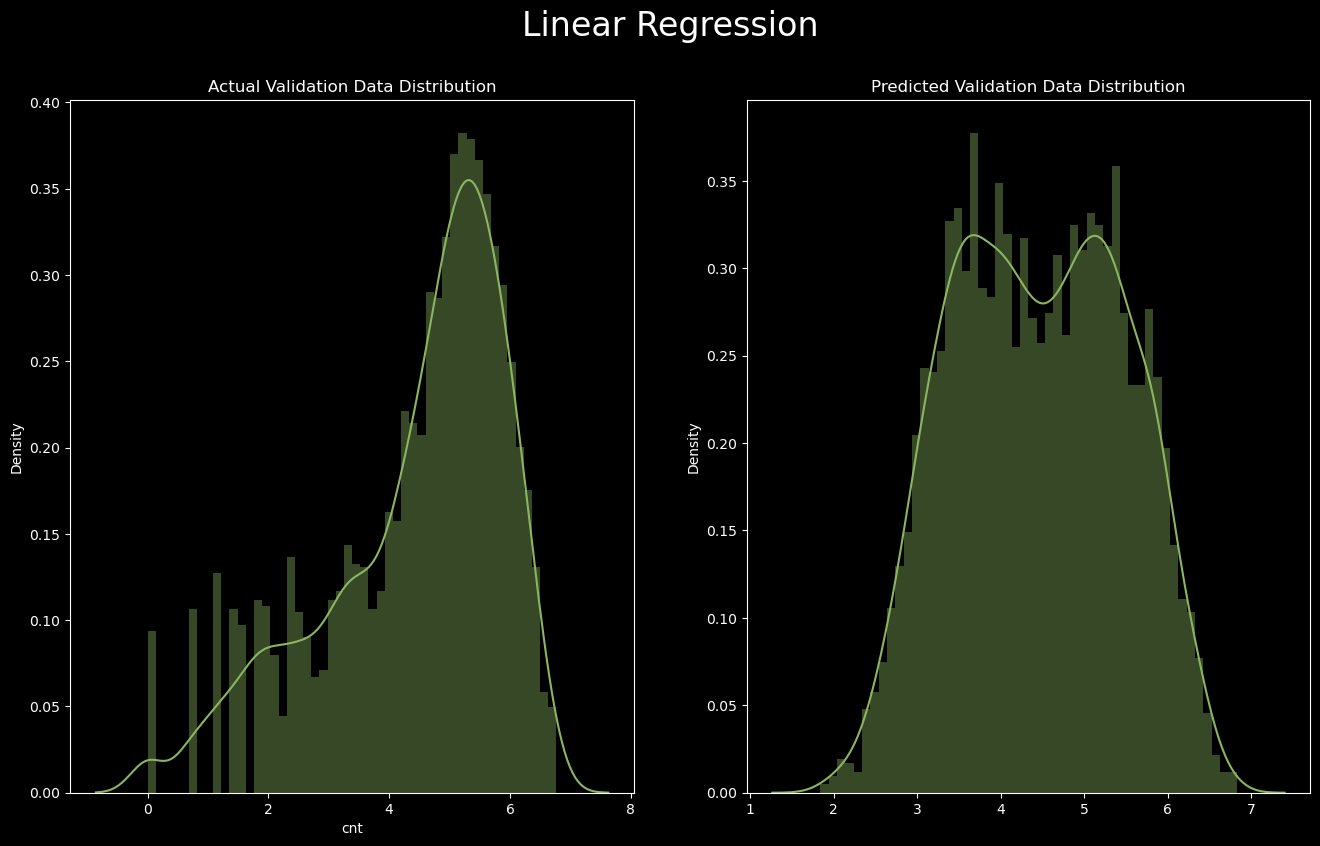

In [24]:
figure, axes = plt.subplots(ncols=2)
figure.set_size_inches(16, 9)

sns.distplot(np.log(y_val), ax=axes[0], bins=50, color='#8cb561')
axes[0].set_title('Actual Validation Data Distribution')
sns.distplot(preds, ax=axes[1], bins=50, color='#8cb561')
axes[1].set_title('Predicted Validation Data Distribution')
plt.suptitle('Linear Regression', fontsize = 24)

plt.savefig('lin_reg_performance_dist.png', dpi=300, transparent=True)
plt.show()

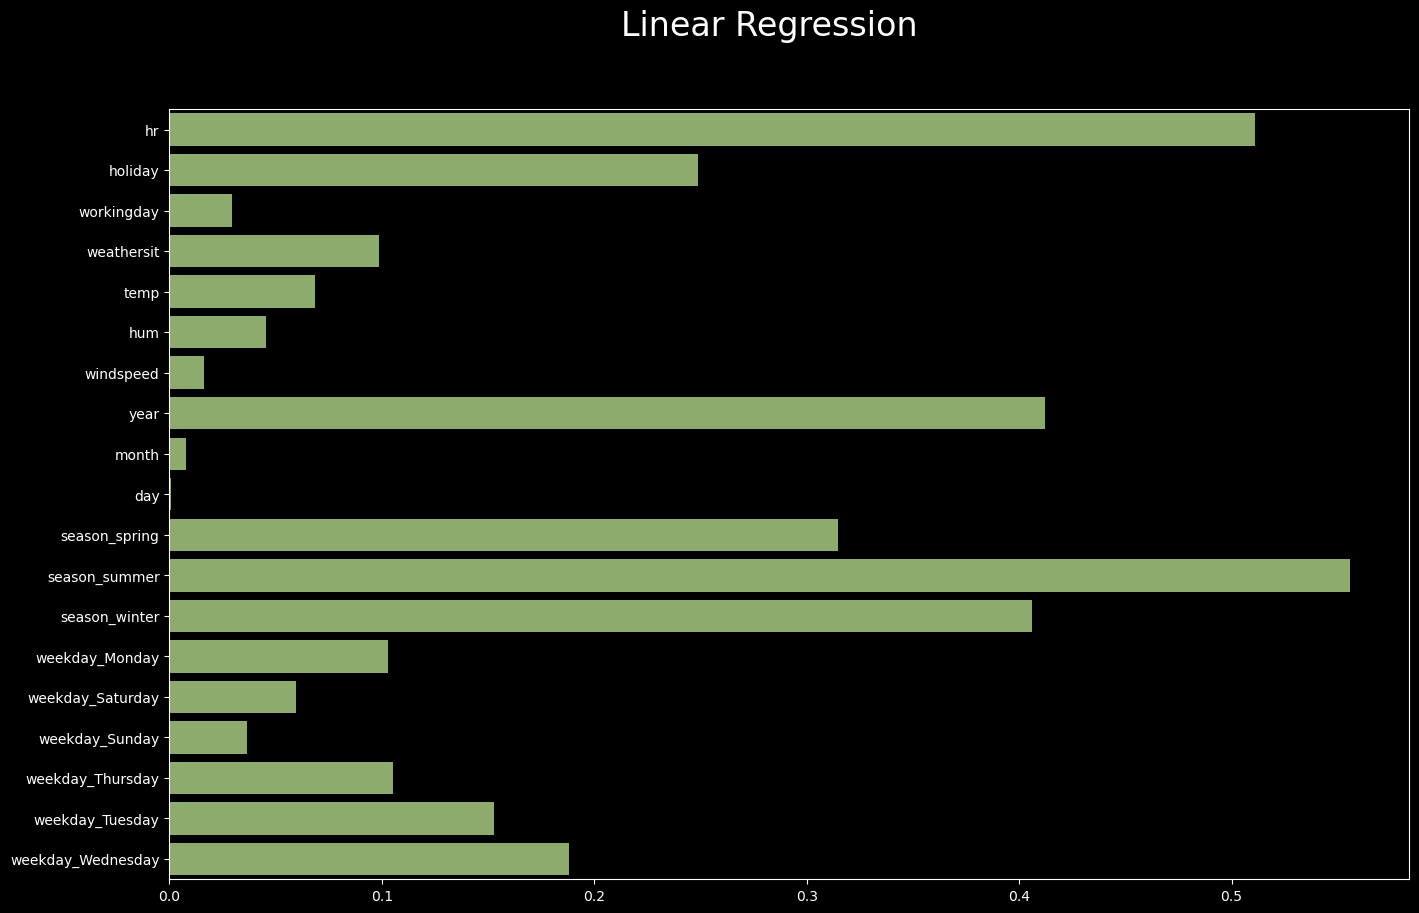

In [25]:
model_coef = np.abs(lin_reg.best_estimator_.named_steps.mdl.coef_)
names = X_train.columns

plt.figure(figsize=(16,10))
sns.barplot(y=names, x=model_coef, color='#8cb561')
plt.suptitle('Linear Regression', fontsize = 24)
plt.savefig('linreg_feature_importance.png', dpi=300, transparent=True)
plt.show()

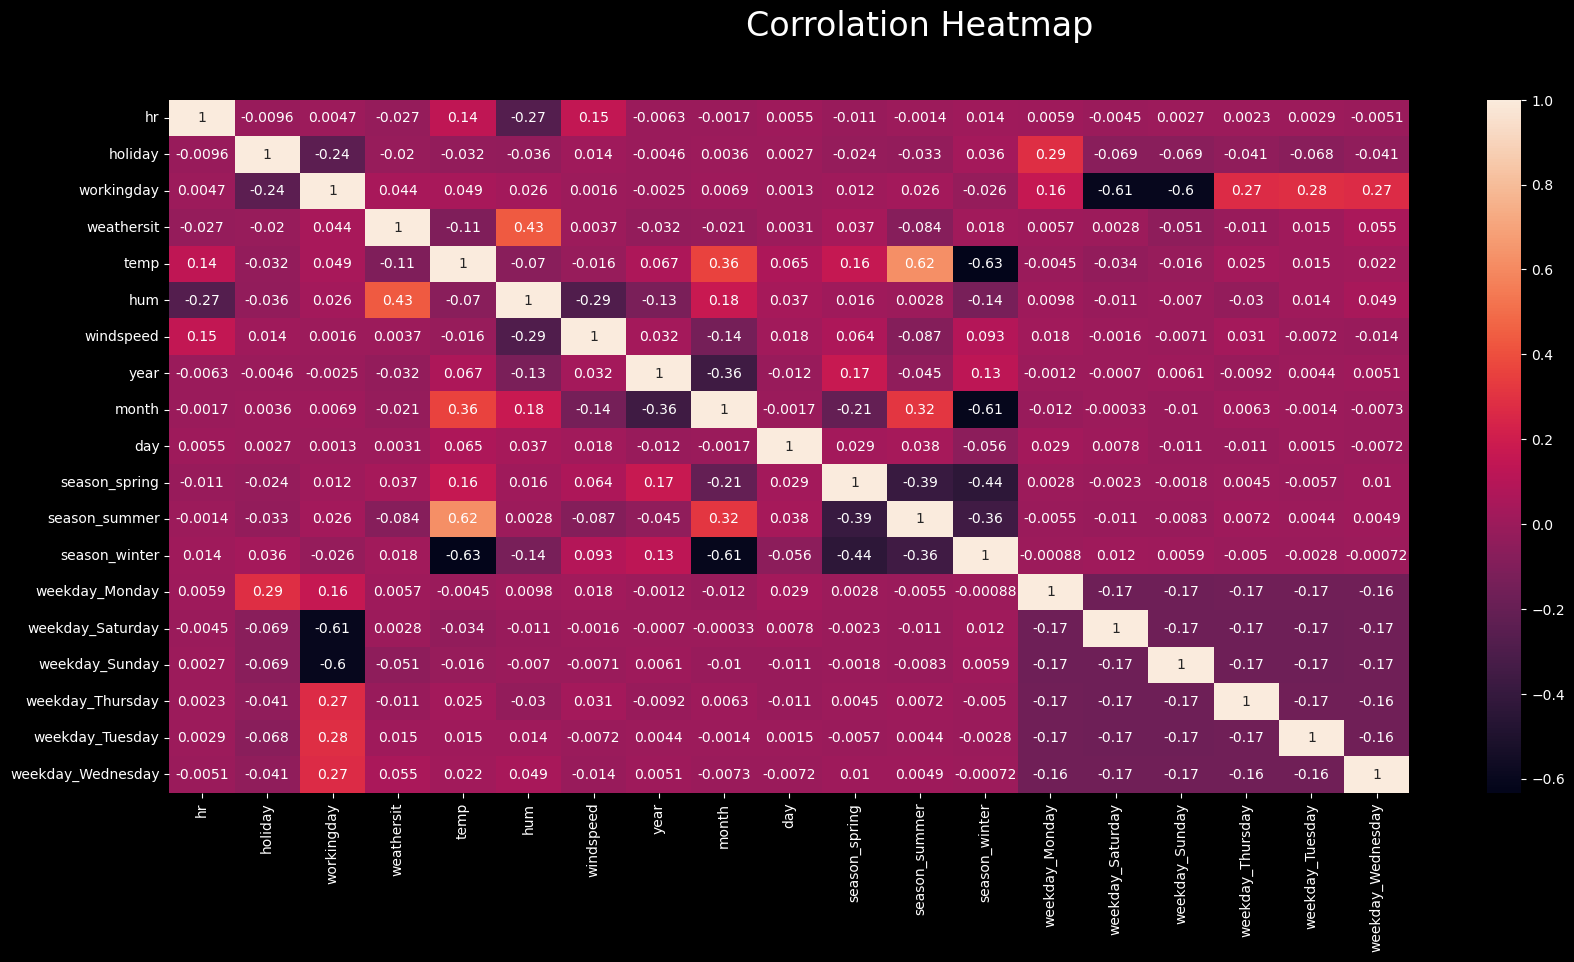

In [26]:
plt.figure(figsize=(20, 9))
heatmap1 = sns.heatmap(X_train.corr(), annot=True)
plt.suptitle('Corrolation Heatmap', fontsize = 24)

plt.savefig('correlation_heatmap.png', dpi=300, transparent=True)
plt.show()

# Ridge

In [27]:
parameters = {
    'mdl__max_iter': [3000], 
    'mdl__alpha': [0.1, 1, 2, 3, 4, 10, 30, 100, 200, 300, 400, 800, 900, 1000]
}

preprocessor = ColumnTransformer(
    transformers=[('scaler', PowerTransformer(), ['temp', 'hum', 'windspeed'])],
    remainder='passthrough'
)

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ("mdl", Ridge())
])

model = Pipeline(steps=[("mdl", Ridge())])

grid_search = GridSearchCV(estimator=model,
                           param_grid=parameters,
                           n_jobs=-2, 
                           cv=10,
                           scoring=rmsle_scorer
                          )

ridge_fitted = grid_search.fit(X_train, np.log(y_train))

print("Best: %f using %s" % (ridge_fitted.best_score_, ridge_fitted.best_params_))

#-----------------------------------------------------------------------------------------------------
preds = ridge_fitted.best_estimator_.predict(X_train)
print(f'Training RMSLE of Ridge: {rmsle(log_y_train, preds, True): .4f}')
mdl_lst.append('Ridge')
train_RMSLE_lst.append(rmsle(log_y_train, preds, True))

log_y_val = np.log(y_val)
preds = ridge_fitted.best_estimator_.predict(X_val)
print(f'Validation RMSLE of Ridge: {rmsle(log_y_val, preds, True): .4f}')
val_RMSLE_lst.append(rmsle(log_y_val, preds, True))

Best: -1.010008 using {'mdl__alpha': 2, 'mdl__max_iter': 3000}
Training RMSLE of Ridge:  1.0081
Validation RMSLE of Ridge:  1.0188


C:\Users\Sean Law\AppData\Local\Temp\ipykernel_6904\93972381.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.log(y_val), ax=axes[0], bins=50, color='#8cb561')
C:\Users\Sean Law\AppData\Local\Temp\ipykernel_6904\93972381.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(preds, ax=axes[1]

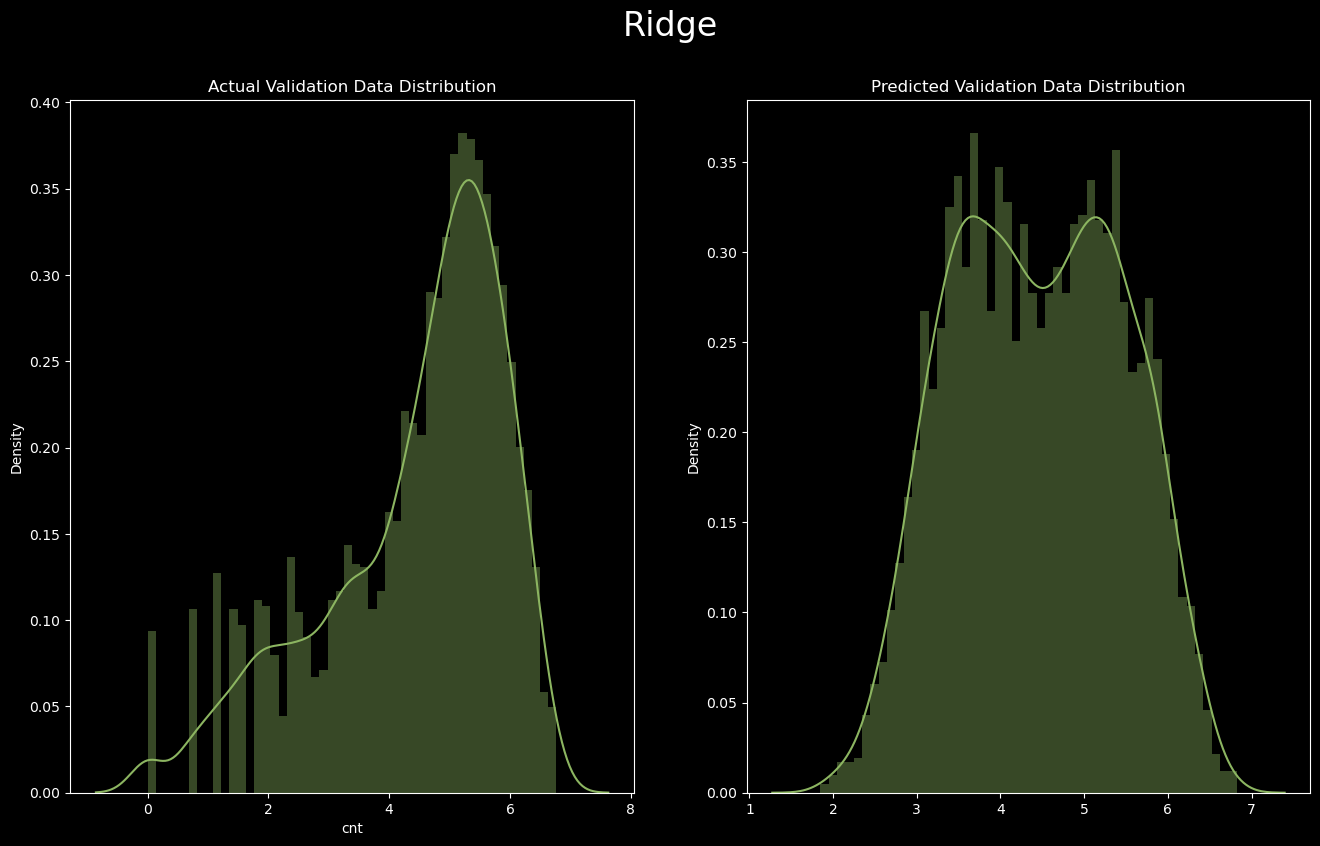

In [28]:
figure, axes = plt.subplots(ncols=2)
figure.set_size_inches(16, 9)

sns.distplot(np.log(y_val), ax=axes[0], bins=50, color='#8cb561')
axes[0].set_title('Actual Validation Data Distribution')
sns.distplot(preds, ax=axes[1], bins=50, color='#8cb561')
axes[1].set_title('Predicted Validation Data Distribution')
plt.suptitle('Ridge', fontsize = 24)

plt.savefig('Ridge_performance_dist.png', dpi=300, transparent=True)
plt.show()

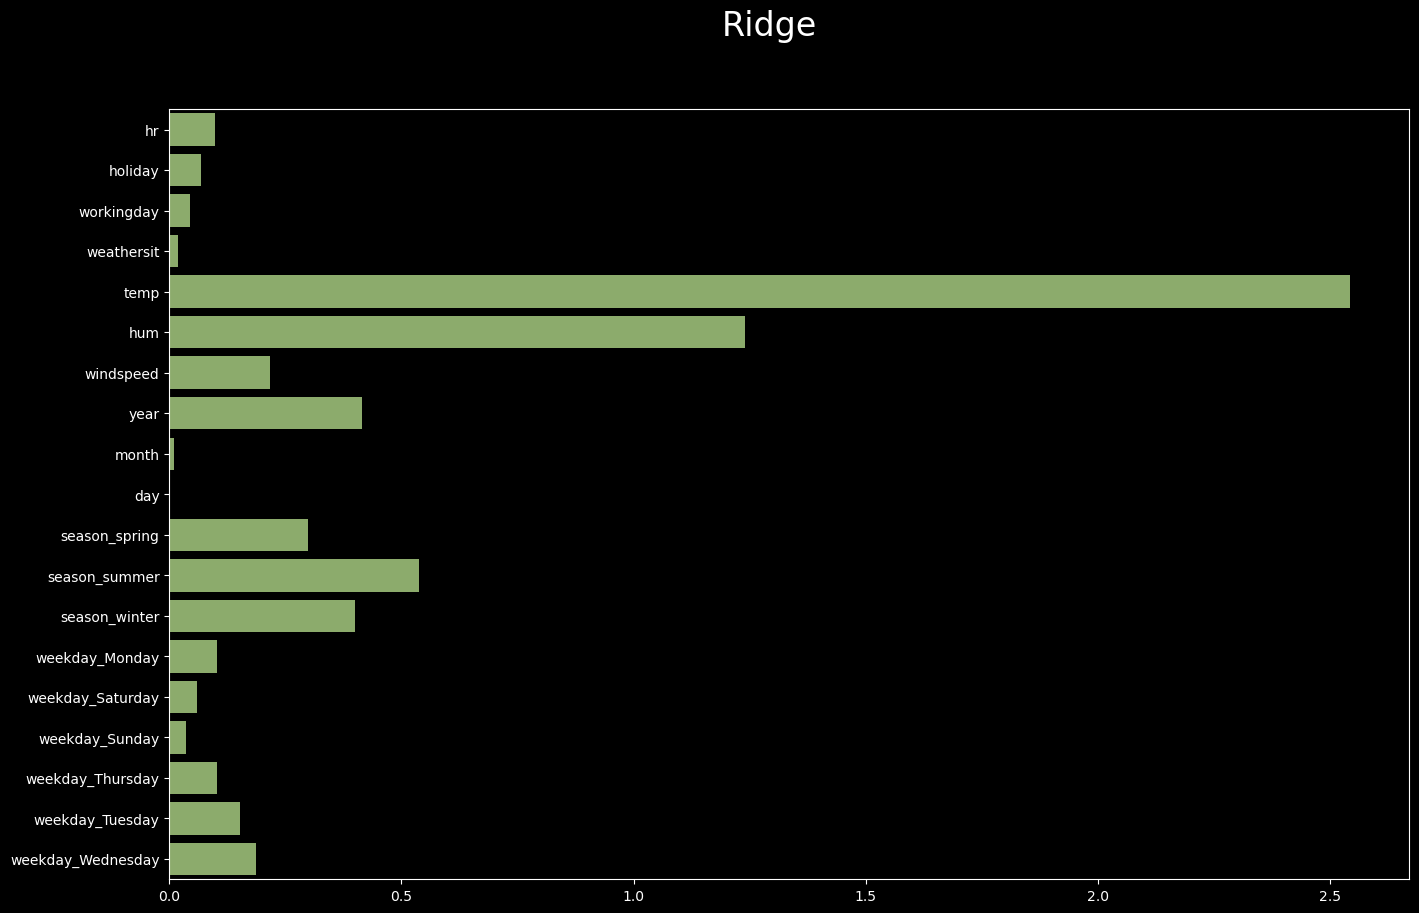

In [29]:
model_coef = np.abs(ridge_fitted.best_estimator_.named_steps.mdl.coef_)
names = X_train.columns

plt.figure(figsize=(16,10))
sns.barplot(y=names, x=model_coef, color='#8cb561')
plt.suptitle('Ridge', fontsize = 24)

plt.savefig('ridge_feature_importance.png', dpi=300, transparent=True)
plt.show()

# Lasso 

In [30]:
parameters = {
    'mdl__max_iter': [3000], 
    'mdl__alpha': [0.1, 1, 2, 3, 4, 10, 30, 100, 200, 300, 400, 800, 900, 1000]
}

preprocessor = ColumnTransformer(
    transformers=[('scaler', PowerTransformer(), ['temp', 'hum', 'windspeed'])],
    remainder='passthrough'
)

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ("mdl", Lasso())
])

grid_search = GridSearchCV(estimator=model,
                           param_grid=parameters,
                           n_jobs=-2, 
                           cv=10,
                           scoring=rmsle_scorer
                          )

lasso_fitted = grid_search.fit(X_train, np.log(y_train))

print("Best: %f using %s" % (lasso_fitted.best_score_, lasso_fitted.best_params_))
#-----------------------------------------------------------------------------------------------------

preds = lasso_fitted.best_estimator_.predict(X_train)
print(f'Training RMSLE of Lasso: {rmsle(log_y_train, preds, True): .4f}')
mdl_lst.append('Lasso')
train_RMSLE_lst.append(rmsle(log_y_train, preds, True))

log_y_val = np.log(y_val)
preds = lasso_fitted.best_estimator_.predict(X_val)
print(f'Validation RMSLE of Lasso: {rmsle(log_y_val, preds, True): .4f}')
val_RMSLE_lst.append(rmsle(log_y_val, preds, True))

Best: -1.042378 using {'mdl__alpha': 0.1, 'mdl__max_iter': 3000}
Training RMSLE of Lasso:  1.0419
Validation RMSLE of Lasso:  1.0532


C:\Users\Sean Law\AppData\Local\Temp\ipykernel_6904\4127419185.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.log(y_val), ax=axes[0], bins=50, color='#8cb561')
C:\Users\Sean Law\AppData\Local\Temp\ipykernel_6904\4127419185.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(preds, ax=axe

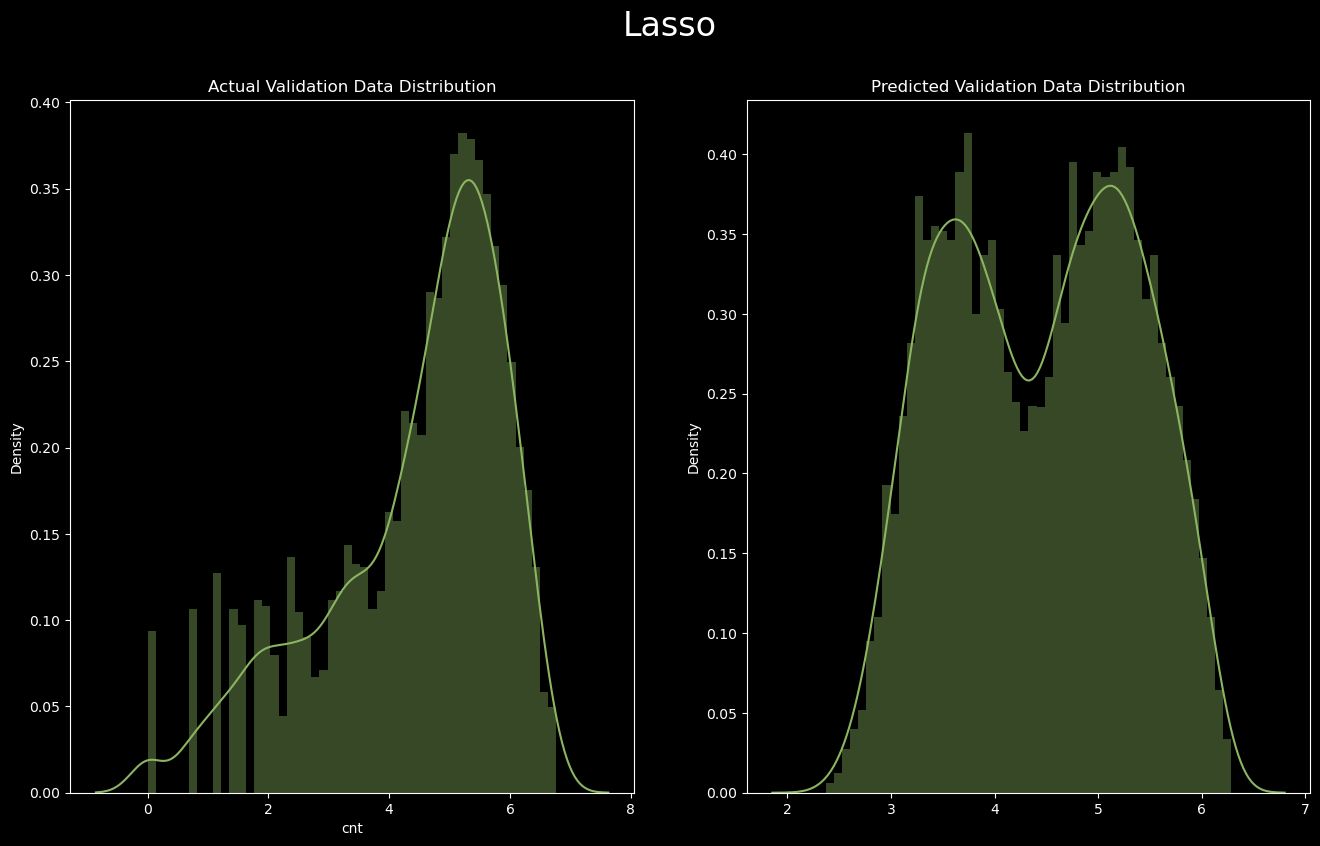

In [31]:
figure, axes = plt.subplots(ncols=2)
figure.set_size_inches(16, 9)

sns.distplot(np.log(y_val), ax=axes[0], bins=50, color='#8cb561')
axes[0].set_title('Actual Validation Data Distribution')
sns.distplot(preds, ax=axes[1], bins=50, color='#8cb561')
axes[1].set_title('Predicted Validation Data Distribution')
plt.suptitle('Lasso', fontsize = 24)

plt.savefig('Lasso_performance_dist.png', dpi=300, transparent=True)
plt.show()

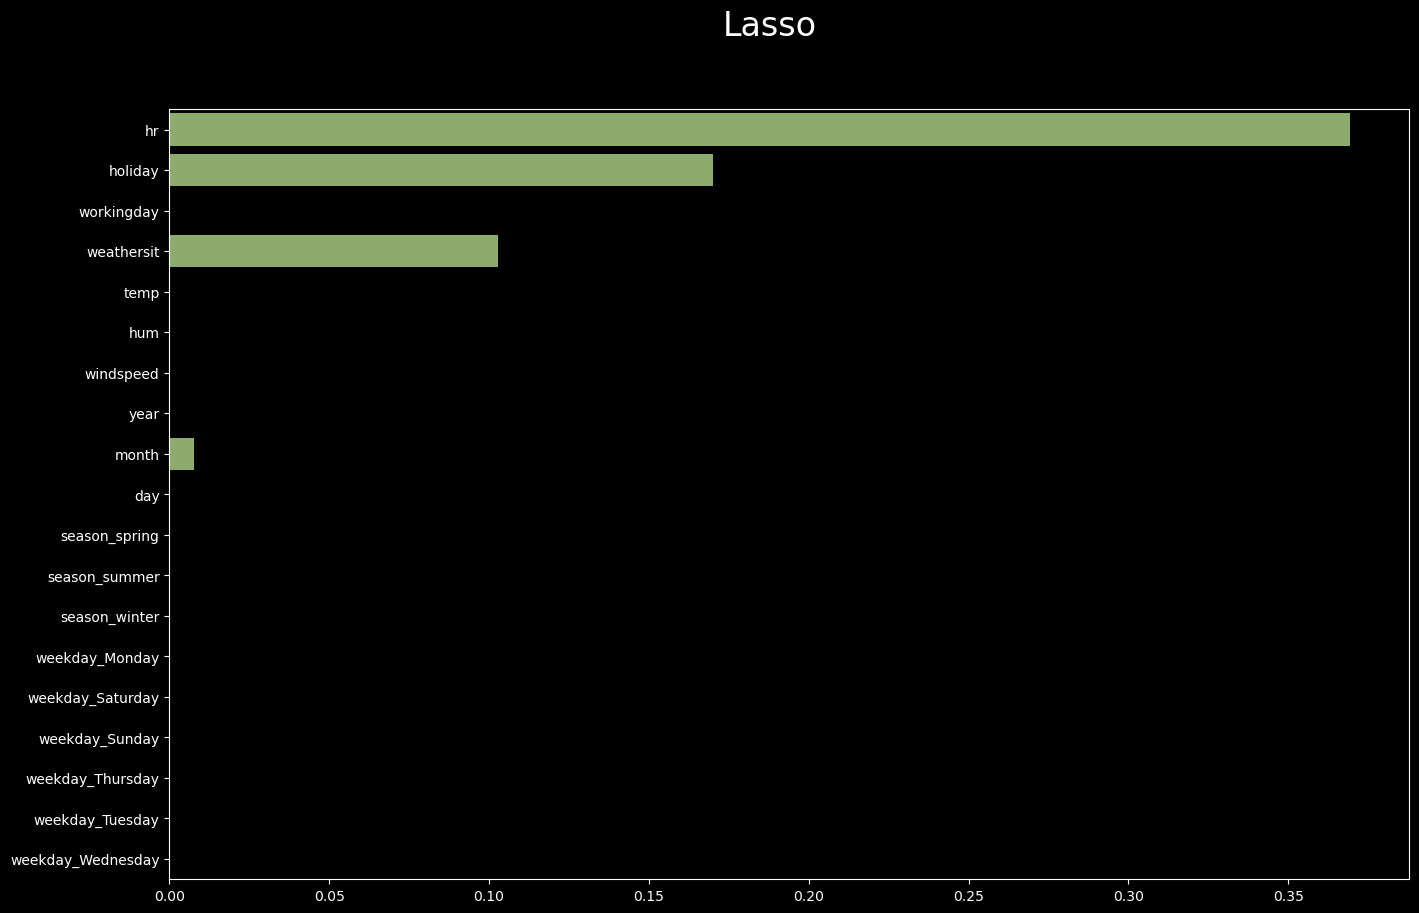

In [32]:
model_coef = np.abs(lasso_fitted.best_estimator_.named_steps.mdl.coef_)
names = X_train.columns

plt.figure(figsize=(16,10))
sns.barplot(y=names, x=model_coef, color='#8cb561')
plt.suptitle('Lasso', fontsize = 24)

plt.savefig('lasso_feature_importance.png', dpi=300, transparent=True)
plt.show()

# Decision Tree

In [33]:
parameters = {
    'mdl__max_depth':[3,5,7,10,15],
    'mdl__min_samples_leaf':[3,5,10],
    'mdl__min_samples_split':[8,10,12,18,20],
    'mdl__criterion':['squared_error', 'friedman_mse', 'absolute_error', 'poisson']
}

preprocessor = ColumnTransformer(
    transformers=[('scaler', PowerTransformer(), ['temp', 'hum', 'windspeed'])],
    remainder='passthrough'
)

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ("mdl", DecisionTreeRegressor())
])

grid_search = GridSearchCV(estimator=model,
                           param_grid=parameters,
                           n_jobs=-2, 
                           cv=5,
                           scoring=rmsle_scorer)

dt_fitted = grid_search.fit(X_train, np.log(y_train))

print("Best: %f using %s" % (dt_fitted.best_score_, dt_fitted.best_params_))

#-----------------------------------------------------------------------------------------------------

preds = dt_fitted.best_estimator_.predict(X_train)
print(f'Training RMSLE of Decision Tree: {rmsle(log_y_train, preds, True): .4f}')
mdl_lst.append('Decision Tree')
train_RMSLE_lst.append(rmsle(log_y_train, preds, True))

log_y_val = np.log(y_val)
preds = dt_fitted.best_estimator_.predict(X_val)
print(f'Validation RMSLE of Decision Tree: {rmsle(log_y_val, preds, True): .4f}')
val_RMSLE_lst.append(rmsle(log_y_val, preds, True))

Best: -0.413744 using {'mdl__criterion': 'poisson', 'mdl__max_depth': 15, 'mdl__min_samples_leaf': 5, 'mdl__min_samples_split': 20}
Training RMSLE of Decision Tree:  0.2932
Validation RMSLE of Decision Tree:  0.4108


C:\Users\Sean Law\AppData\Local\Temp\ipykernel_6904\1573971532.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.log(y_val), ax=axes[0], bins=50, color='#8cb561')
C:\Users\Sean Law\AppData\Local\Temp\ipykernel_6904\1573971532.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(preds, ax=axe

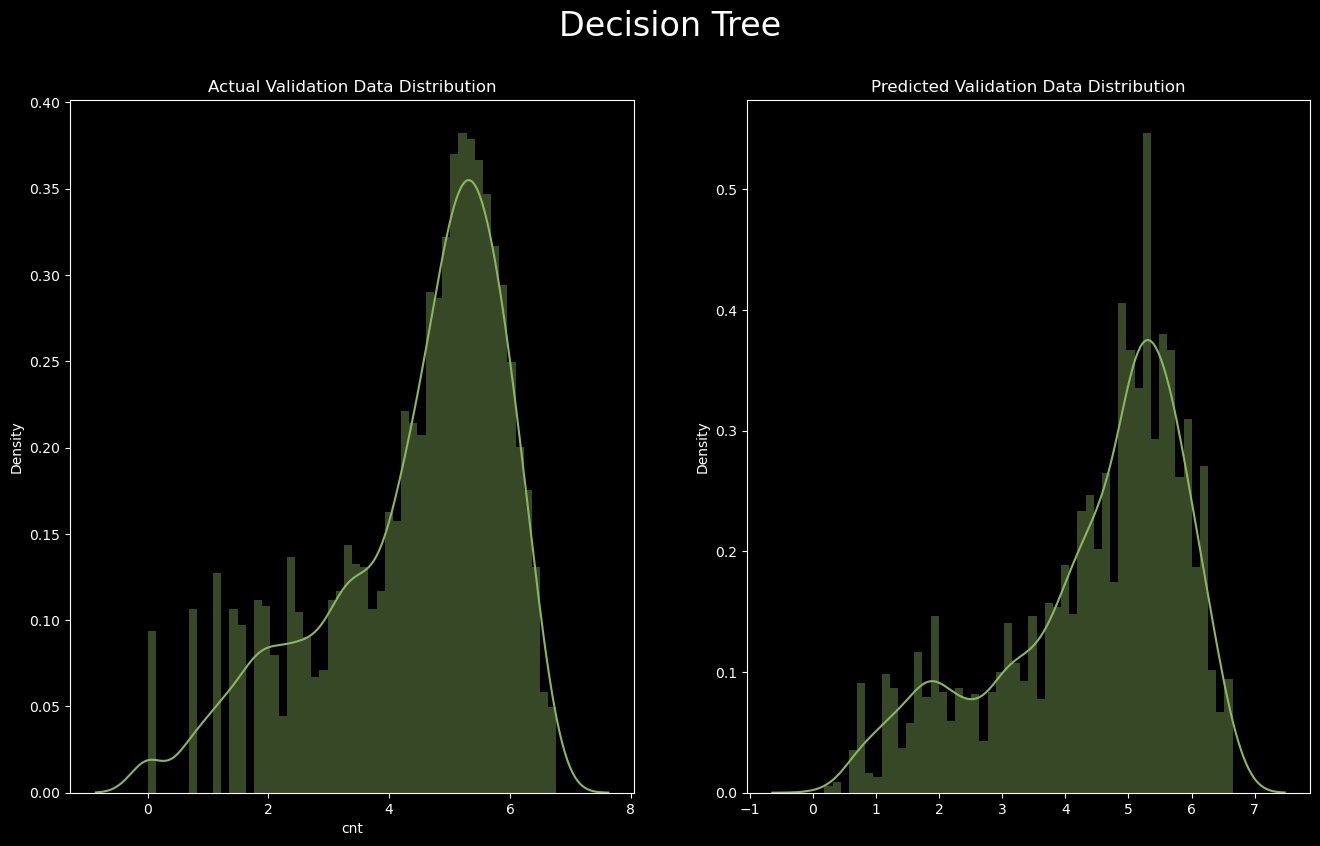

In [34]:
figure, axes = plt.subplots(ncols=2)
figure.set_size_inches(16, 9)

sns.distplot(np.log(y_val), ax=axes[0], bins=50, color='#8cb561')
axes[0].set_title('Actual Validation Data Distribution')
sns.distplot(preds, ax=axes[1], bins=50, color='#8cb561')
axes[1].set_title('Predicted Validation Data Distribution')
plt.suptitle('Decision Tree', fontsize = 24)

plt.savefig('DT_performance_dist.png', dpi=300, transparent=True)
plt.show()

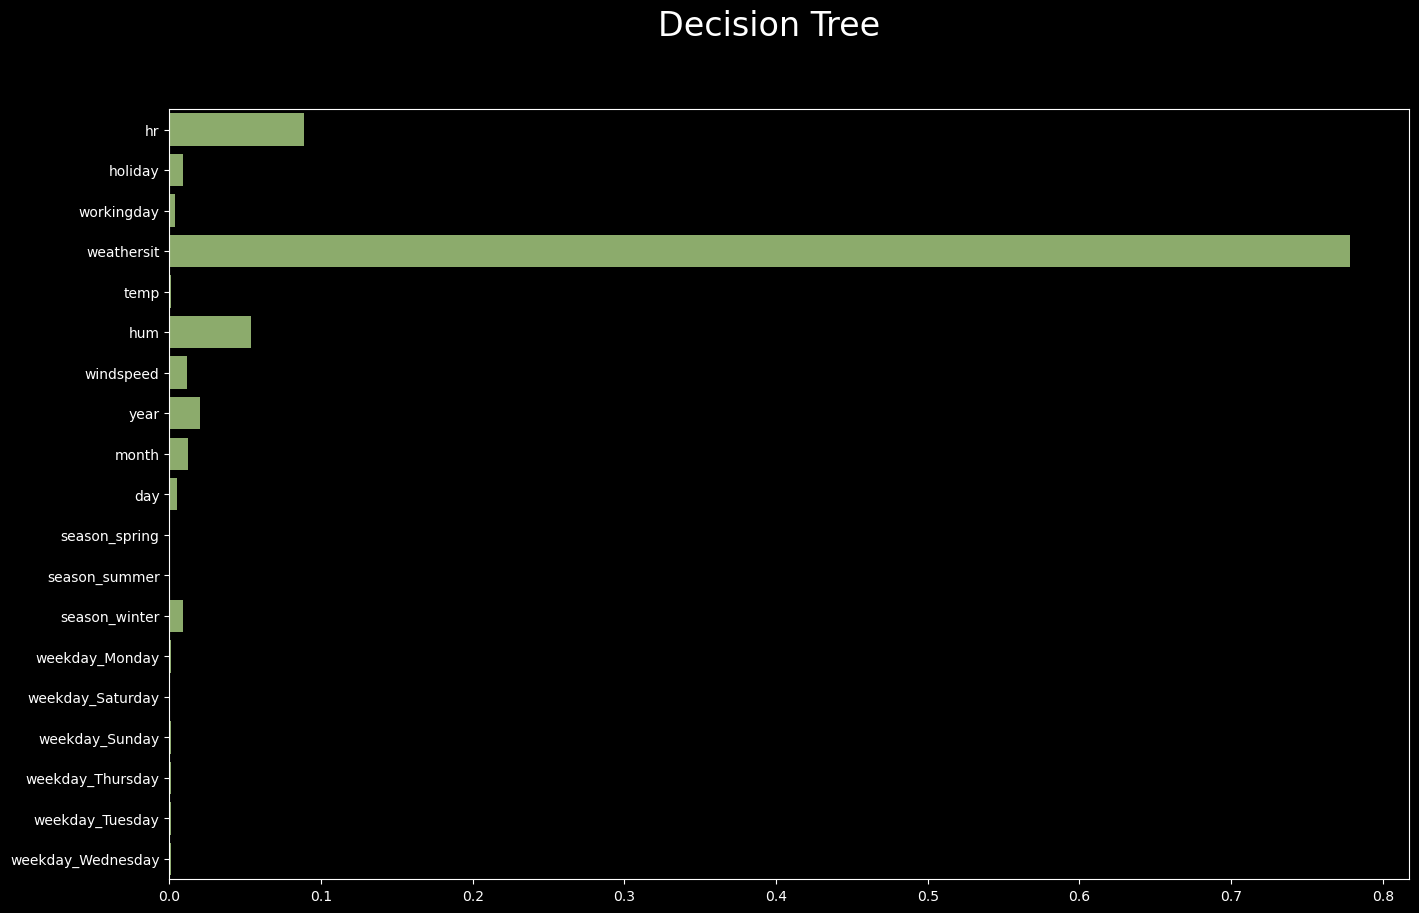

In [35]:
model_coef = np.abs(dt_fitted.best_estimator_._final_estimator.feature_importances_)
names = X_train.columns

plt.figure(figsize=(16,10))
sns.barplot(y=names, x=model_coef, color='#8cb561')
plt.suptitle('Decision Tree', fontsize = 24)

plt.savefig('DT_feature_importance.png', dpi=300, transparent=True)
plt.show()

#  Bagging 

In [36]:
parameters = {
    'mdl__max_features': [2,8,15,30,None],
    'mdl__n_estimators': [10,50,100,250,350,450]
}

preprocessor = ColumnTransformer(
    transformers=[('scaler', PowerTransformer(), ['temp', 'hum', 'windspeed'])],
    remainder='passthrough'
)

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ("mdl", BaggingRegressor())
])

grid_search = GridSearchCV(estimator=model,
                           param_grid=parameters,
                           n_jobs=-2, 
                           cv=5,
                           scoring=rmsle_scorer)

bagging_fitted = grid_search.fit(X_train, np.log(y_train))

print("Best: %f using %s" % (bagging_fitted.best_score_, bagging_fitted.best_params_))

#-----------------------------------------------------------------------------------------------------

preds = bagging_fitted.best_estimator_.predict(X_train)
print(f'Training RMSLE of Bagging: {rmsle(log_y_train, preds, True): .4f}')
mdl_lst.append('Bagging')
train_RMSLE_lst.append(rmsle(log_y_train, preds, True))

log_y_val = np.log(y_val)
preds = bagging_fitted.best_estimator_.predict(X_val)
print(f'Validation RMSLE of Bagging: {rmsle(log_y_val, preds, True): .4f}')
val_RMSLE_lst.append(rmsle(log_y_val, preds, True))

C:\Users\Sean Law\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
60 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Sean Law\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Sean Law\anaconda3\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Sean Law\anaconda3\Lib\site-packages\sklearn\pipeline.py", line 420, in fit
    self._final_

Best: -0.377688 using {'mdl__max_features': 15, 'mdl__n_estimators': 450}
Training RMSLE of Bagging:  0.1392
Validation RMSLE of Bagging:  0.3686


C:\Users\Sean Law\AppData\Local\Temp\ipykernel_6904\667201091.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.log(y_val), ax=axes[0], bins=50, color='#8cb561')
C:\Users\Sean Law\AppData\Local\Temp\ipykernel_6904\667201091.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(preds, ax=axes[

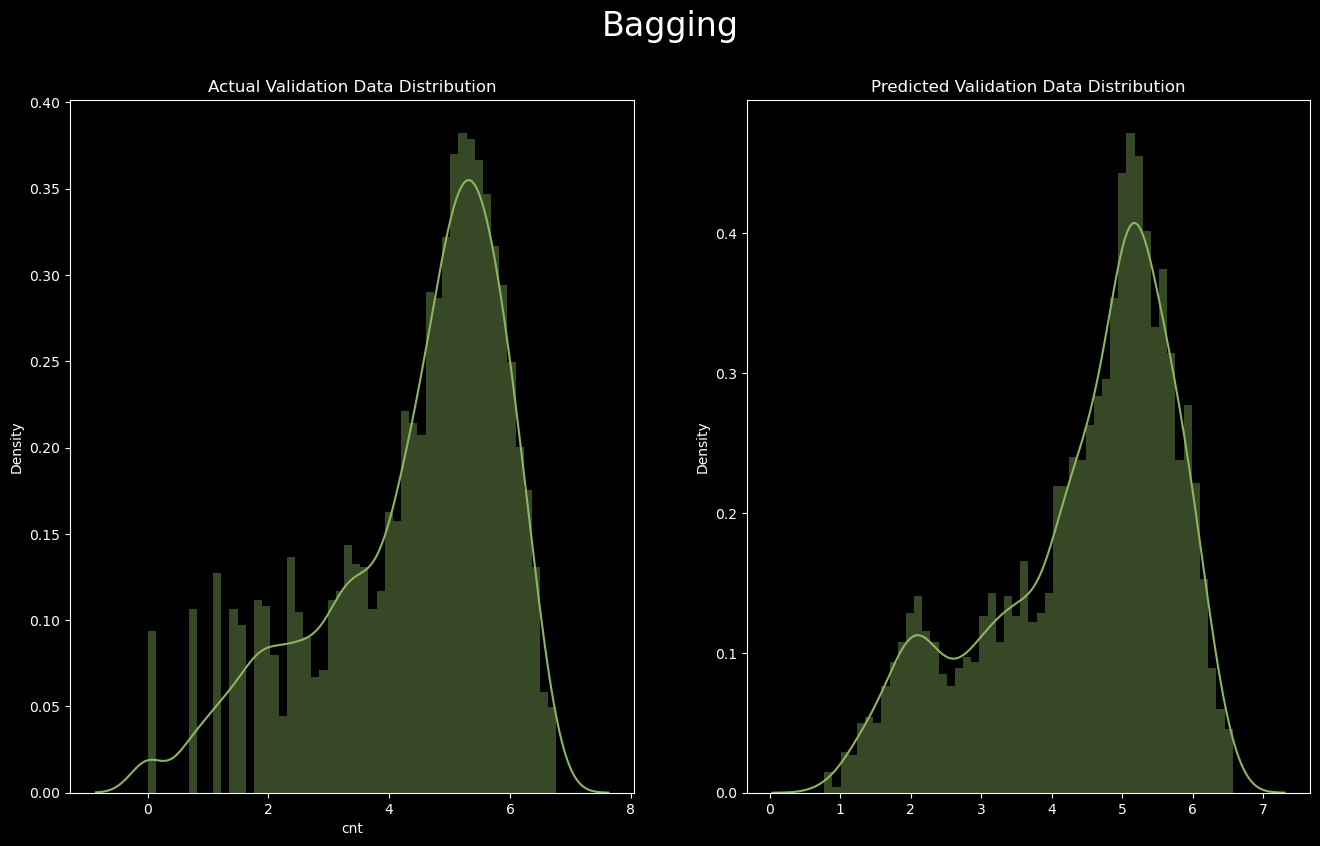

In [37]:
figure, axes = plt.subplots(ncols=2)
figure.set_size_inches(16, 9)

sns.distplot(np.log(y_val), ax=axes[0], bins=50, color='#8cb561')
axes[0].set_title('Actual Validation Data Distribution')
sns.distplot(preds, ax=axes[1], bins=50, color='#8cb561')
axes[1].set_title('Predicted Validation Data Distribution')
plt.suptitle('Bagging', fontsize = 24)

plt.savefig('Bagging_performance_dist.png', dpi=300, transparent=True)
plt.show()

# Random forest

In [38]:
parameters = {
    "mdl__bootstrap": [True, False],
    "mdl__max_depth": [2,4,8,16,32,80],
    'mdl__max_features': [2,8,15,30],
    'mdl__min_samples_leaf': [3,5,8],
    'mdl__min_samples_split': [8,10],
    'mdl__n_estimators': [5,10,50,100,250]
}

preprocessor = ColumnTransformer(
    transformers=[('scaler', PowerTransformer(), ['temp', 'hum', 'windspeed'])],
    remainder='passthrough'
)

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ("mdl", RandomForestRegressor())
])

grid_search = GridSearchCV(estimator=model,
                           param_grid=parameters,
                           n_jobs=-2, 
                           cv=5,
                           scoring=rmsle_scorer)

rf_fitted = grid_search.fit(X_train, np.log(y_train))

print("Best: %f using %s" % (rf_fitted.best_score_, rf_fitted.best_params_))

#-----------------------------------------------------------------------------------------------------

preds = rf_fitted.best_estimator_.predict(X_train)
print(f'Training RMSLE of Random Forest: {rmsle(log_y_train, preds, True): .4f}')
mdl_lst.append('Random Forest')
train_RMSLE_lst.append(rmsle(log_y_train, preds, True))

log_y_val = np.log(y_val)
preds = rf_fitted.best_estimator_.predict(X_val)
print(f'Validation RMSLE of Random Forest: {rmsle(log_y_val, preds, True): .4f}')
val_RMSLE_lst.append(rmsle(log_y_val, preds, True))

Best: -0.336422 using {'mdl__bootstrap': True, 'mdl__max_depth': 16, 'mdl__max_features': 15, 'mdl__min_samples_leaf': 3, 'mdl__min_samples_split': 8, 'mdl__n_estimators': 250}
Training RMSLE of Random Forest:  0.2192
Validation RMSLE of Random Forest:  0.3400


C:\Users\Sean Law\AppData\Local\Temp\ipykernel_6904\1149693901.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.log(y_val), ax=axes[0], bins=50, color='#8cb561')
C:\Users\Sean Law\AppData\Local\Temp\ipykernel_6904\1149693901.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(preds, ax=axe

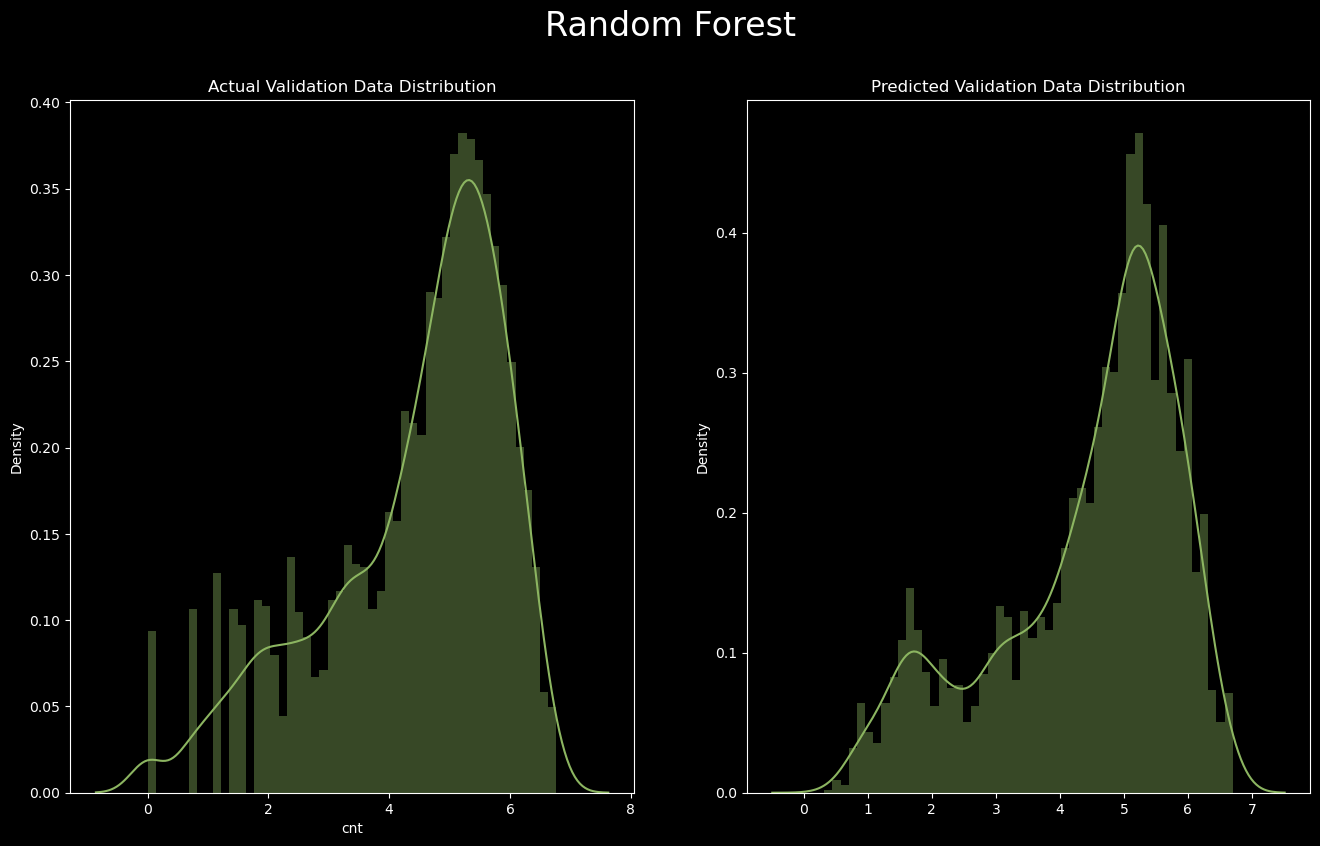

In [39]:
figure, axes = plt.subplots(ncols=2)
figure.set_size_inches(16, 9)

sns.distplot(np.log(y_val), ax=axes[0], bins=50, color='#8cb561')
axes[0].set_title('Actual Validation Data Distribution')
sns.distplot(preds, ax=axes[1], bins=50, color='#8cb561')
axes[1].set_title('Predicted Validation Data Distribution')
plt.suptitle('Random Forest', fontsize = 24)

plt.savefig('RF_performance_dist.png', dpi=300, transparent=True)
plt.show()

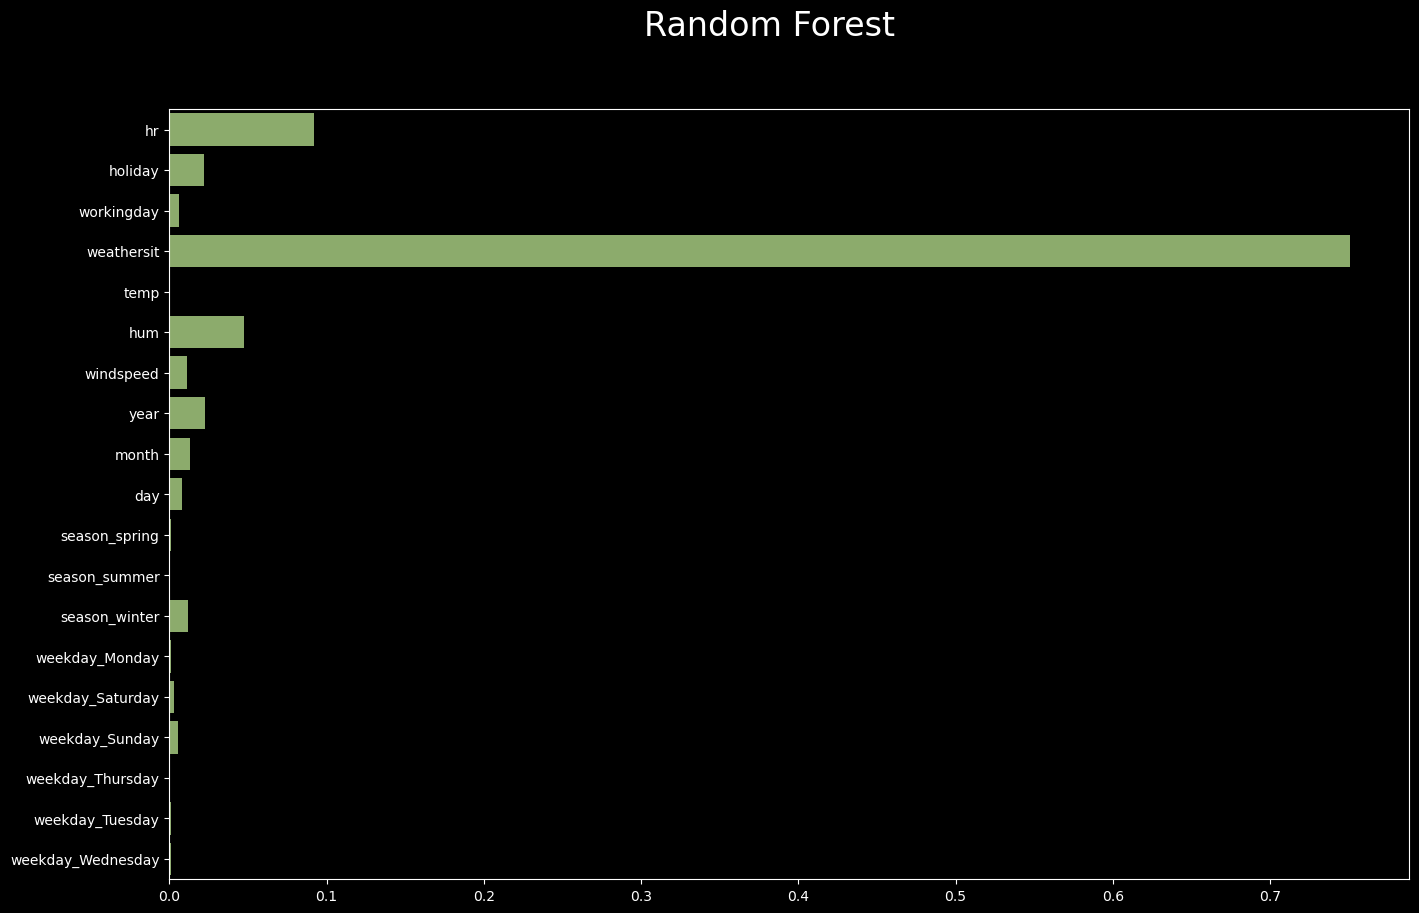

In [40]:
model_coef = np.abs(rf_fitted.best_estimator_._final_estimator.feature_importances_)
names = X_train.columns

plt.figure(figsize=(16,10))
sns.barplot(y=names, x=model_coef, color='#8cb561')
plt.suptitle('Random Forest', fontsize = 24)

plt.savefig('RT_feature_importance.png', dpi=300, transparent=True)
plt.show()

# Gradient Boosting

In [41]:
parameters = {
    'mdl__n_estimators': [5,10,50,100,250],
    "mdl__max_depth": [2,4,16,80,None],
    'mdl__min_samples_split': [8, 12,50],
    'mdl__max_features': [2, 5]
}

preprocessor = ColumnTransformer(
    transformers=[('scaler', PowerTransformer(), ['temp', 'hum', 'windspeed'])],
    remainder='passthrough'
)

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ("mdl", GradientBoostingRegressor())
])

grid_search = GridSearchCV(estimator=model,
                           param_grid=parameters, 
                           n_jobs=-2, 
                           cv=5,
                           scoring=rmsle_scorer)

gb_fitted = grid_search.fit(X_train, np.log(y_train))

print("Best: %f using %s" % (gb_fitted.best_score_, gb_fitted.best_params_))
#-----------------------------------------------------------------------------------------------------

preds = gb_fitted.best_estimator_.predict(X_train)
print(f'Training RMSLE of Gradient Boosting: {rmsle(log_y_train, preds, True): .4f}')
mdl_lst.append('Boosting')
train_RMSLE_lst.append(rmsle(log_y_train, preds, True))

log_y_val = np.log(y_val)
preds = gb_fitted.best_estimator_.predict(X_val)
print(f'Validation RMSLE of Gradient Boosting: {rmsle(log_y_val, preds, True): .4f}')
val_RMSLE_lst.append(rmsle(log_y_val, preds, True))

Best: -0.312291 using {'mdl__max_depth': 80, 'mdl__max_features': 5, 'mdl__min_samples_split': 50, 'mdl__n_estimators': 100}
Training RMSLE of Gradient Boosting:  0.1113
Validation RMSLE of Gradient Boosting:  0.3090


C:\Users\Sean Law\AppData\Local\Temp\ipykernel_6904\1706586874.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.log(y_val), ax=axes[0], bins=50, color='#8cb561')
C:\Users\Sean Law\AppData\Local\Temp\ipykernel_6904\1706586874.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(preds, ax=axe

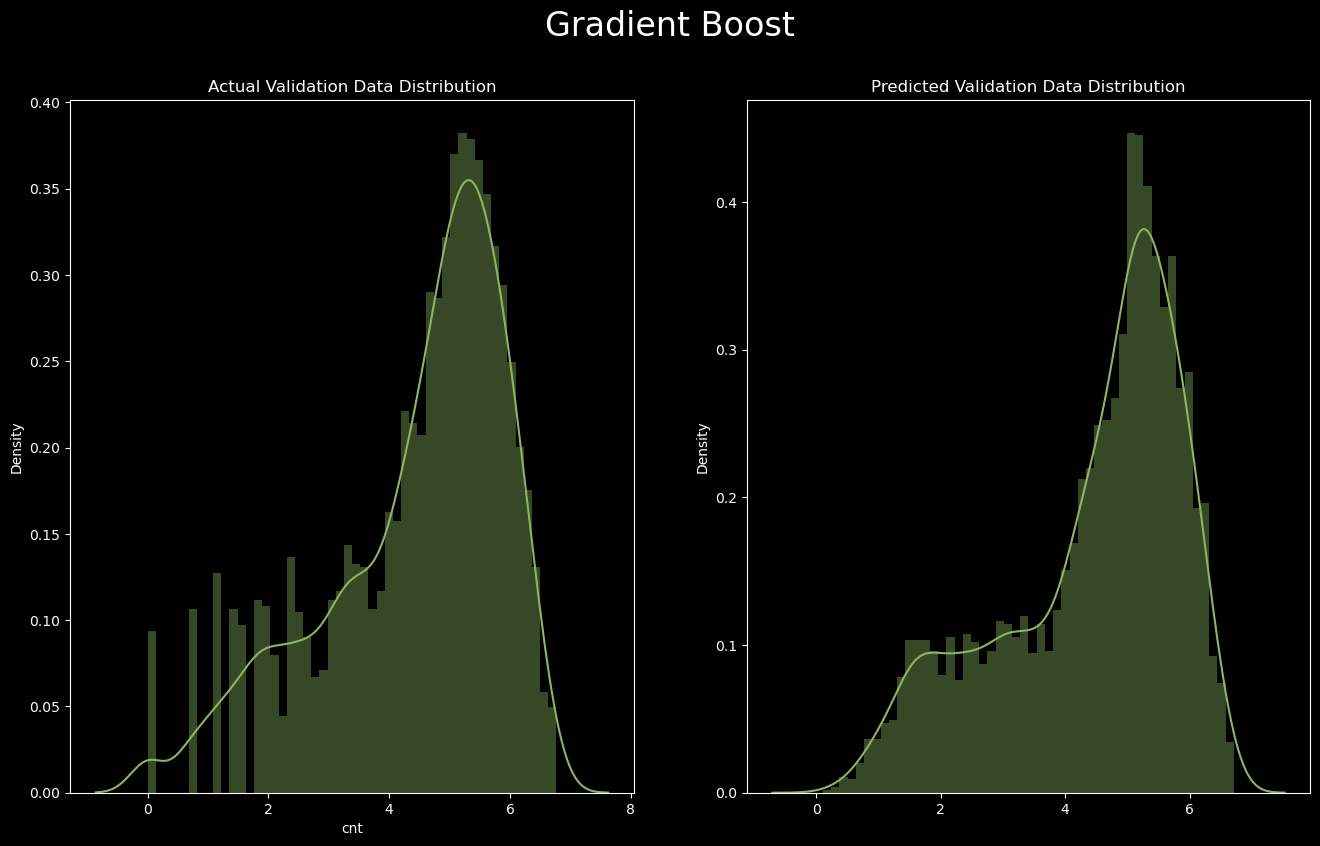

In [42]:
figure, axes = plt.subplots(ncols=2)
figure.set_size_inches(16, 9)

sns.distplot(np.log(y_val), ax=axes[0], bins=50, color='#8cb561')
axes[0].set_title('Actual Validation Data Distribution')
sns.distplot(preds, ax=axes[1], bins=50, color='#8cb561')
axes[1].set_title('Predicted Validation Data Distribution')
plt.suptitle('Gradient Boost', fontsize = 24)

plt.savefig('GB_performance_dist.png', dpi=300, transparent=True)
plt.show()

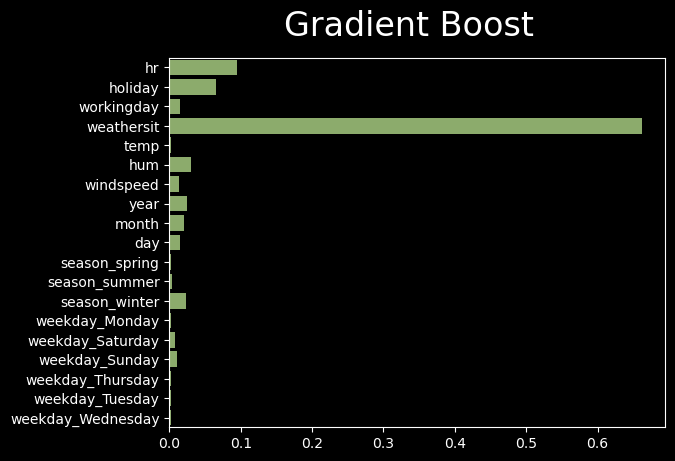

In [43]:
model_coef = np.abs(gb_fitted.best_estimator_._final_estimator.feature_importances_)
names = X_train.columns

figure.set_size_inches(16, 9)
sns.barplot(y=names, x=model_coef, color='#8cb561')
plt.suptitle('Gradient Boost', fontsize = 24)

plt.savefig('GB_feature_importance.png', dpi=300, transparent=True)
plt.show()

# Neural Network

In [44]:
parameters = {   
    'mdl__hidden_layer_sizes': [(200,200,200), (100,100,100), 
                                (200,200,200,200), (100,100,100,100),
                               ],
    'mdl__activation': ['relu','tanh','logistic'],
    'mdl__alpha': [0.0001, 0.05],
    'mdl__learning_rate': ['constant','adaptive'],
    'mdl__solver': ['adam']
}

model = Pipeline(steps=[("scaler", PowerTransformer()),
                        ("mdl", MLPRegressor())])

grid_search = GridSearchCV(estimator=model,
                           param_grid=parameters,
                           n_jobs=-2, 
                           cv=5,
                           scoring=rmsle_scorer)

nn_fitted = grid_search.fit(X_train, np.log(y_train))

print("Best: %f using %s" % (nn_fitted.best_score_, nn_fitted.best_params_))
#-----------------------------------------------------------------------------------------------------

preds = nn_fitted.best_estimator_.predict(X_train)
print(f'Training RMSLE of Neural Network: {rmsle(log_y_train, preds, True): .4f}')
mdl_lst.append('Neural Network')
train_RMSLE_lst.append(rmsle(log_y_train, preds, True))

log_y_val = np.log(y_val)
preds = nn_fitted.best_estimator_.predict(X_val)
print(f'Validation RMSLE of Neural Network: {rmsle(log_y_val, preds, True): .4f}')
val_RMSLE_lst.append(rmsle(log_y_val, preds, True))

Best: -0.348221 using {'mdl__activation': 'tanh', 'mdl__alpha': 0.05, 'mdl__hidden_layer_sizes': (200, 200, 200), 'mdl__learning_rate': 'adaptive', 'mdl__solver': 'adam'}
Training RMSLE of Neural Network:  0.2522
Validation RMSLE of Neural Network:  0.3135


C:\Users\Sean Law\AppData\Local\Temp\ipykernel_6904\3821796322.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.log(y_val), ax=axes[0], bins=50, color='#8cb561')
C:\Users\Sean Law\AppData\Local\Temp\ipykernel_6904\3821796322.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(preds, ax=axe

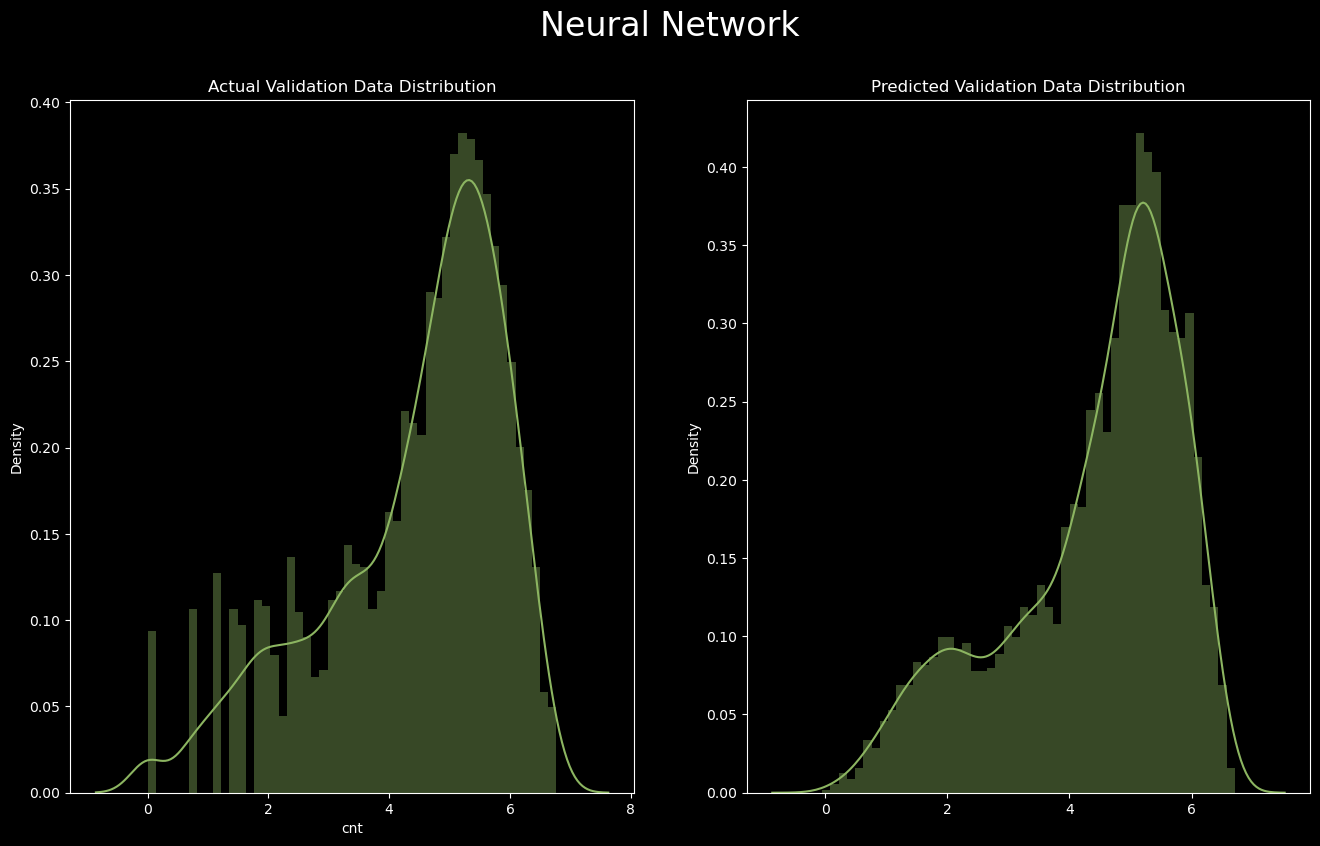

In [45]:
figure, axes = plt.subplots(ncols=2)
figure.set_size_inches(16, 9)

sns.distplot(np.log(y_val), ax=axes[0], bins=50, color='#8cb561')
axes[0].set_title('Actual Validation Data Distribution')
sns.distplot(preds, ax=axes[1], bins=50, color='#8cb561')
axes[1].set_title('Predicted Validation Data Distribution')
plt.suptitle('Neural Network', fontsize = 24)

plt.savefig('NN_performance_dist.png', dpi=300, transparent=True)
plt.show()

# Summary table

In [46]:
comparison = pd.DataFrame({
    'model' : mdl_lst,
    'train_RMSLE' : train_RMSLE_lst,
    'val_RMSLE' : val_RMSLE_lst
})
display(comparison)

,model,train_RMSLE,val_RMSLE
0,Linear Trend,1.11421,1.12656
1,ARIMA,4.72057,4.67715
2,Linear Regression,1.00780,1.01846
3,Ridge,1.00807,1.01881
4,Lasso,1.04193,1.05321
5,Decision Tree,0.29324,0.41075
6,Bagging,0.13918,0.36862
7,Random Forest,0.21917,0.33998
8,Boosting,0.11133,0.30901
9,Neural Network,0.25215,0.31346


### Neural Network on Test

In [47]:
preds = nn_fitted.best_estimator_.predict(X_test)
print(f'Test RMSLE of Neural Network: {rmsle(np.log(y_test), preds, True): .4f}')

Test RMSLE of Neural Network:  0.3884


C:\Users\Sean Law\AppData\Local\Temp\ipykernel_6904\3791824821.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.log(y_val), ax=axes[0], bins=50, color='#8cb561')
C:\Users\Sean Law\AppData\Local\Temp\ipykernel_6904\3791824821.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(preds, ax=axe

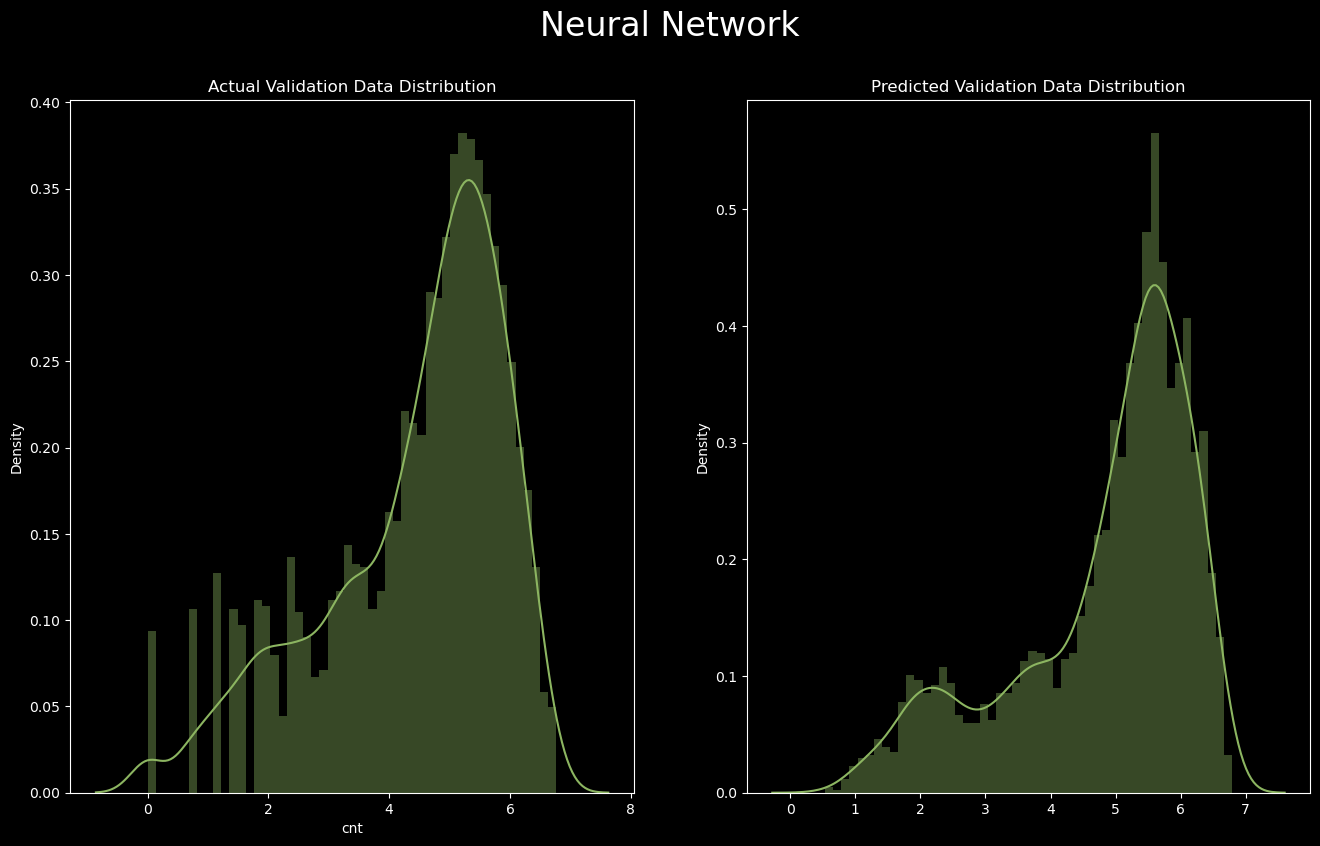

In [48]:
figure, axes = plt.subplots(ncols=2)
figure.set_size_inches(16, 9)

sns.distplot(np.log(y_val), ax=axes[0], bins=50, color='#8cb561')
axes[0].set_title('Actual Validation Data Distribution')
sns.distplot(preds, ax=axes[1], bins=50, color='#8cb561')
axes[1].set_title('Predicted Validation Data Distribution')
plt.suptitle('Neural Network', fontsize = 24)

plt.savefig('NN_TEST_SET_performance_dist.png', dpi=300, transparent=True)
plt.show()

### Decision Tree on Test

In [49]:
preds = dt_fitted.best_estimator_.predict(X_test)
print(f'Test RMSLE of Decision Tree: {rmsle(np.log(y_test), preds, True): .4f}')

Test RMSLE of Decision Tree:  0.4697


C:\Users\Sean Law\AppData\Local\Temp\ipykernel_6904\2756351385.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.log(y_val), ax=axes[0], bins=50, color='#8cb561')
C:\Users\Sean Law\AppData\Local\Temp\ipykernel_6904\2756351385.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(preds, ax=axe

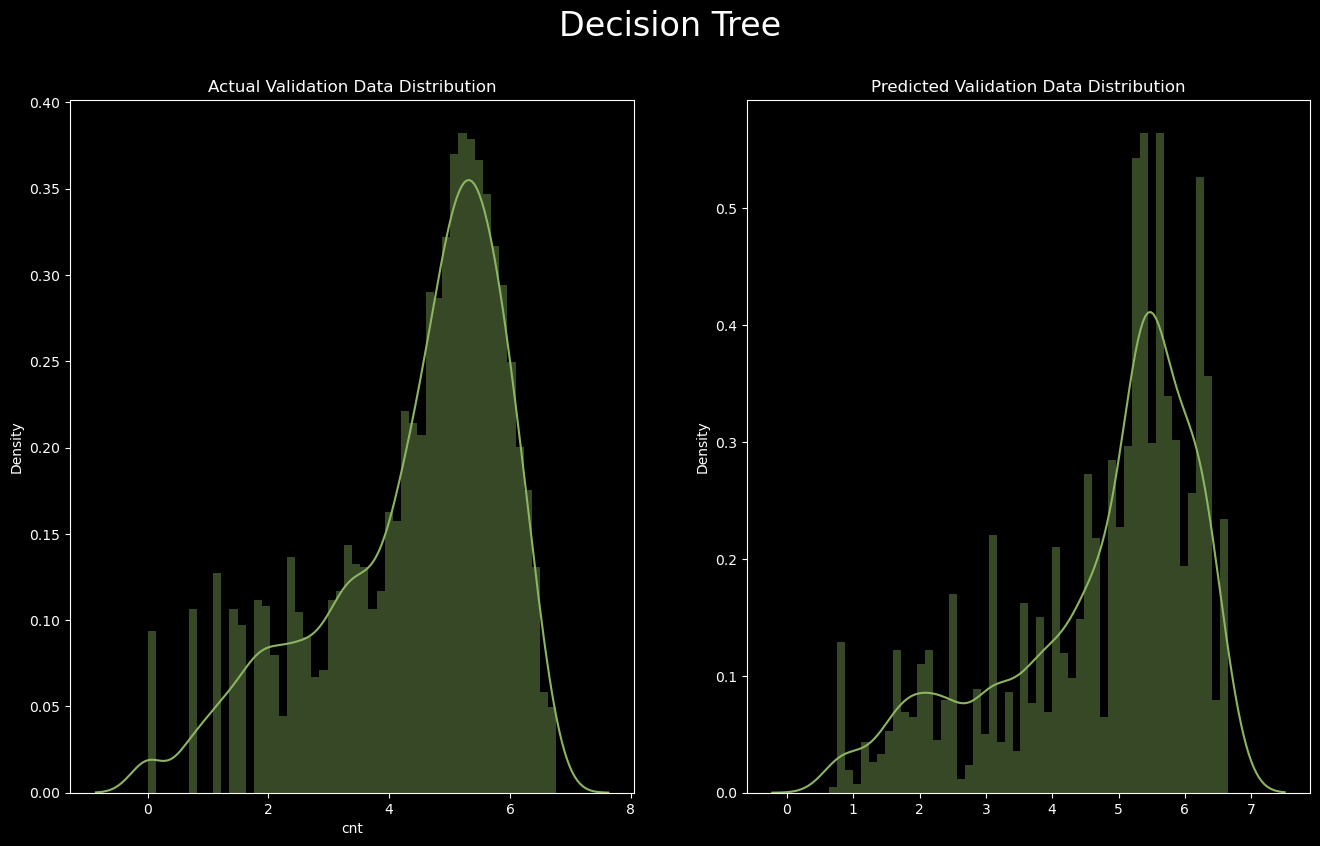

In [50]:
figure, axes = plt.subplots(ncols=2)
figure.set_size_inches(16, 9)

sns.distplot(np.log(y_val), ax=axes[0], bins=50, color='#8cb561')
axes[0].set_title('Actual Validation Data Distribution')
sns.distplot(preds, ax=axes[1], bins=50, color='#8cb561')
axes[1].set_title('Predicted Validation Data Distribution')
plt.suptitle('Decision Tree', fontsize = 24)

plt.savefig('DT_TEST_SET_performance_dist.png', dpi=300, transparent=True)
plt.show()

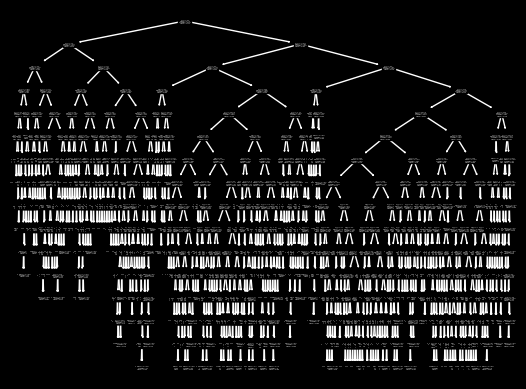

In [51]:
figure.set_size_inches(50, 50)
tree.plot_tree(dt_fitted.best_estimator_._final_estimator)
plt.show()